<a href="https://colab.research.google.com/github/Wyw021214/ISP_autism/blob/main/AAL_Neurotypical_ASD_Predicted_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install -q nilearn nibabel pandas==2.2.2 numpy==1.23.5 matplotlib requests boto3 awscli seaborn
!pip install -q nibabel nilearn numpy scikit-learn matplotlib pandas scipy
!pip install -q hcp_utils brainspace actflow


In [8]:
!pip install --upgrade --force-reinstall numpy==1.23.5 pandas==2.2.2

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninsta

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Necessary for visualization
from nilearn import plotting, datasets

import h5py
import pkg_resources
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import sys
sys.path.insert(0, '../../')

#Used for plotting brain images inline
from wbplot import pscalar
import matplotlib.image as mpimg

import ActflowToolbox as actflow

<ipython-input-1-7b31a84453b1>:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
aal_network_labels = [
    "Visual", "Visual", "Visual", "Visual", "Somatomotor", "Somatomotor", "Somatomotor", "Somatomotor",
    "DorsalAttention", "DorsalAttention", "DorsalAttention", "DorsalAttention",
    "VentralAttention", "VentralAttention", "VentralAttention", "VentralAttention",
    "Limbic", "Limbic", "Limbic", "Limbic",
    "Frontoparietal", "Frontoparietal", "Frontoparietal", "Frontoparietal",
    "DefaultMode", "DefaultMode", "DefaultMode", "DefaultMode",
    "Subcortical", "Subcortical", "Subcortical", "Subcortical",
]

#Convert to numerical labels
network_dict = {net: idx for idx, net in enumerate(sorted(set(aal_network_labels)))}
network_labels_numeric = [network_dict[net] for net in aal_network_labels]

# Compute network order
netorder = np.argsort(network_labels_numeric)  # Sort ROIs by network

# Step 5: Print network order for verification
print(f"Network order indices: {netorder}")

Network order indices: [27 24 25 26 11  8  9 10 21 20 22 23 16 17 18 19  6  5  4  7 30 28 29 31
 15 13 12 14  3  2  1  0]


Add the following files as a shortcut to your MyDrive on Google to ensure the following code works:

[HCP_1200_processed
](https://https://drive.google.com/drive/folders/1BKbSPy4TGZqK4LRcVV2GVAfj5QGy1h_b?usp=share_link)

[hcp1200_subjects.txt](https://https://drive.google.com/file/d/1wDWNO8N_6RhmgyS8sNXSz7UwpzeNAD_v/view?usp=share_link)

In [10]:
# Paths
output_base_dir = "/content/drive/MyDrive/HCP_1200_processed"

# List of subjects to process
subject_list_path = "/content/drive/MyDrive/hcp1200_subjects.txt"
with open(subject_list_path, "r") as file:
    subject_ids = [line.strip() for line in file.readlines()]

subject_ids = subject_ids  # Use the first 30 subjects
N_SUBJECTS = len(subject_ids)

task_conditions = ["WM_LR_0bk_body", "WM_LR_2bk_body", "WM_LR_0bk_faces", "WM_LR_2bk_faces",
  "WM_LR_0bk_places", "WM_LR_2bk_places", "WM_LR_0bk_tools", "WM_LR_2bk_tools",
 "WM_RL_0bk_body", "WM_RL_2bk_body", "WM_RL_0bk_faces", "WM_RL_2bk_faces",
  "WM_RL_0bk_places", "WM_RL_2bk_places", "WM_RL_0bk_tools", "WM_RL_2bk_tools",
 "SOCIAL_LR_mental", "SOCIAL_LR_rnd", "SOCIAL_RL_mental", "SOCIAL_RL_rnd",
 ]

# Task and resting-state data
N_PARCELS = 84  # Number of AAL parcels
N_TASKS = 20     # Number of tasks
TIME_CHUNK = 1200  # Average over 1200 time points

# Initialize lists to store valid subject data
valid_subjects = []
restdata_list = []
activations_list = []
problematic_subjects = []  # Store subjects with incorrect task shape

# Load data for each subject
for subj_idx, subject_id in enumerate(subject_ids):
    subject_output_dir = os.path.join(output_base_dir, subject_id)

    # Load resting-state data
    rest_file = os.path.join(subject_output_dir, "rest.npy")
    if os.path.exists(rest_file):
        subject_restdata = np.load(rest_file)  # Shape: (84, timepoints)

        # Average over chunks of 1200 time points
        num_chunks = subject_restdata.shape[1] // TIME_CHUNK
        subject_restdata_avg = np.mean(
            subject_restdata[:, :num_chunks * TIME_CHUNK].reshape(N_PARCELS, num_chunks, TIME_CHUNK),
            axis=1
        )  # Shape: (84, 1200)

    else:
        print(f"WARNING: Missing resting-state data for Subject {subject_id}")
        continue  # Skip this subject

    # Load task activations
    task_file = os.path.join(subject_output_dir, "task.npy")
    if os.path.exists(task_file):
        subject_taskdata = np.load(task_file)  # Expected Shape: (84, 4)

        # Check for shape mismatch
        if subject_taskdata.shape[1] != N_TASKS:
            print(f"WARNING: Subject {subject_id} has task data shape {subject_taskdata.shape}, expected (84, {N_TASKS})")
            problematic_subjects.append(subject_id)
            continue  # Skip this subject

    else:
        print(f"WARNING: Missing task data for Subject {subject_id}")
        continue  # Skip this subject

    # Only add valid subjects
    valid_subjects.append(subject_id)
    restdata_list.append(subject_restdata_avg)
    activations_list.append(subject_taskdata)

# Convert lists to numpy arrays
restdata = np.stack(restdata_list, axis=2)  # Shape: (84, 1200, valid_subjects_count)
activations_bycond = np.stack(activations_list, axis=2)  # Shape: (84, 20, valid_subjects_count)

# Verify final shape
print("Final Restdata shape:", restdata.shape)  # Expected: (84, 1200, valid_subjects_count)
print("Final Activations_bycond shape:", activations_bycond.shape)  # Expected: (84, 20, valid_subjects_count)


Final Restdata shape: (84, 1200, 1096)
Final Activations_bycond shape: (84, 20, 1096)


In [11]:
import numpy as np

def safe_corrcoef(X):
    """Compute correlation matrix with small regularization to avoid NaNs."""
    X = X - np.mean(X, axis=1, keepdims=True)  # Zero-center
    X_std = np.std(X, axis=1, keepdims=True)

    # Regularization: Avoid division by zero
    X_std[X_std < 1e-10] = 1e-10  # Small nonzero value to prevent NaNs
    X = X / X_std

    # Use np.nan_to_num to handle potential NaNs during correlation calculation
    corr_matrix = np.corrcoef(X)
    corr_matrix = np.nan_to_num(corr_matrix)
    return corr_matrix

# Replace NaNs with Small Nonzero Value
restdata = np.nan_to_num(restdata, nan=1e-10)  # Replace NaNs

# Compute Pearson Correlation FC (Keeps All ROIs)
restFC_corr = np.zeros((N_PARCELS, N_PARCELS, restdata.shape[2]))

for subj_idx in range(restdata.shape[2]):
    subject_restdata = restdata[:, :, subj_idx]

    if np.isnan(subject_restdata).sum() > 0:
        print(f"Warning: Subject {subj_idx} contains NaNs in `restdata`. Skipping FC calculation.")
        continue

    restFC_corr[:, :, subj_idx] = safe_corrcoef(subject_restdata)

nan_count = np.isnan(restFC_corr).sum()
if nan_count > 0:
    print(f"Warning: {nan_count} NaN values detected in `restFC_corr` after computation.")

print("Functional Connectivity Matrix Computed Successfully")


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Functional Connectivity Matrix Computed Successfully


In [12]:
%%time
# Perform activity flow mapping (doing simple actflow using Pearson corr to test the code and data is processed in the correct format)
print("== Activity flow mapping results, correlation-based resting-state FC, 20 task conditions ==")
actflowOutput_restFCCorr_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_corr)

== Activity flow mapping results, correlation-based resting-state FC, 20 task conditions ==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 20 conditions across 84 nodes, p-values based on 1096 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.63, t-value vs. 0: 140.79, p-value vs. 0: 0.0
 
Mean % variance explained (R^2 score, coeff. of determination) = -393.04
 
Mean MAE (mean absolute error) = 2.25
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-learn.org/stab

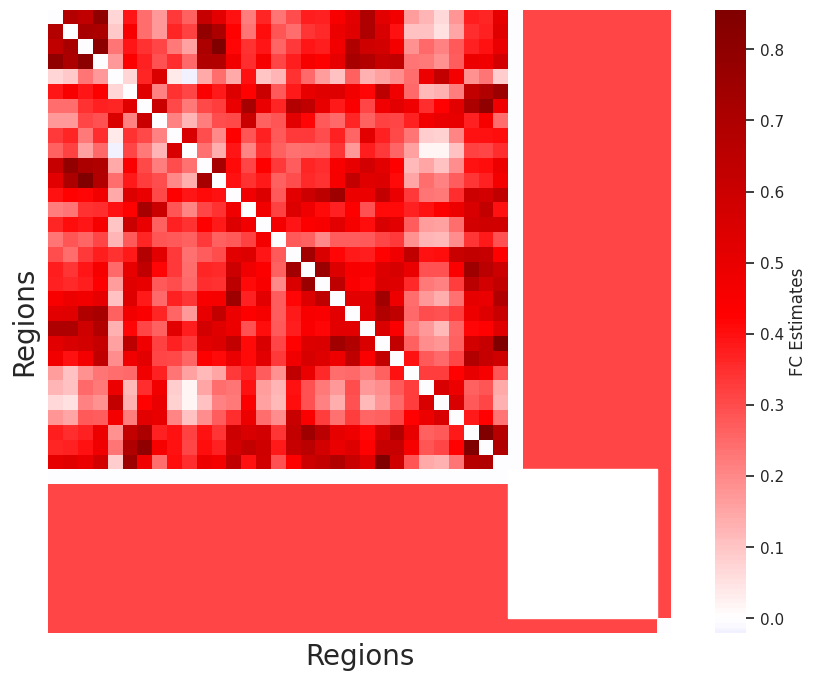

In [13]:
#Visualize FC matrix
fcmat=np.mean(restFC_corr[netorder,:,:][:,netorder,:],axis=2)
fig=actflow.tools.addNetColors_Seaborn(fcmat)

[Text(54.75, 0.5, 'Regions')]

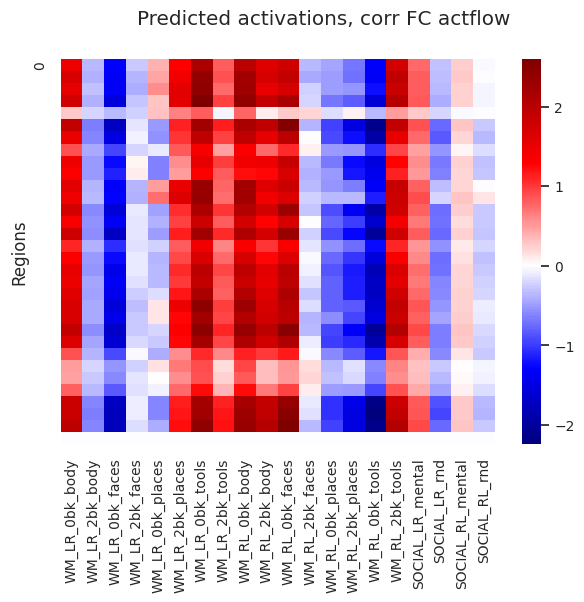

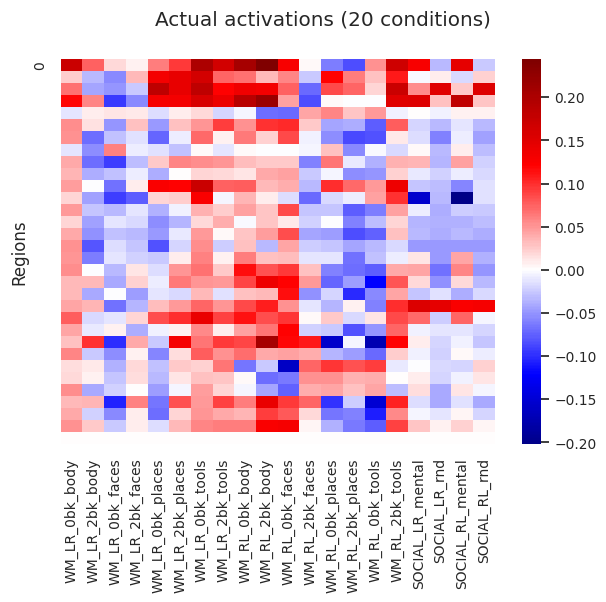

In [14]:
#Plot figures to compare corr FC of predicted vs actual activations
plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'],axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=task_conditions)
ax.figure.suptitle('Predicted activations, corr FC actflow')
ax.set(ylabel='Regions')

plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(activations_bycond,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=task_conditions)
ax.figure.suptitle('Actual activations (20 conditions)')
ax.set(ylabel='Regions')

#Multi-Regression FC


In [15]:
!pip install nilearn actflow

In [16]:
%%time
# Number of nodes (ROIs)
numnodes = restdata.shape[0]

# Number of subjects
numsubjs = restdata.shape[2]

# Initialize Multi-Regression FC matrix
restFC_mreg = np.zeros((numnodes, numnodes, numsubjs)) #(ROIs, time series, number of subjects)

# Compute regression-based FC for each subject using actflow
for subj in range(numsubjs):
    restFC_mreg[:, :, subj] = actflow.connectivity_estimation.multregconn(restdata[:, :, subj])

print("Computed Multiple Regression-Based Resting-State FC Matrix")
print(f"Shape: {restFC_mreg.shape}")

Computed Multiple Regression-Based Resting-State FC Matrix
Shape: (84, 84, 1096)
CPU times: user 2h 31min 32s, sys: 3.97 s, total: 2h 31min 36s
Wall time: 20min 1s


In [17]:
# Step 1: Get task indices for SOCIAL_MENTAL
social_mental_task_indices = [16, 18]  # 0-based indexing for SOCIAL_LR_mental and SOCIAL_RL_mental

# Step 2: Select activation data for those tasks (actual and predicted)
# activations_bycond: shape (84, 20, N_subjects)
# restFC_mreg: shape (84, 84, N_subjects)

# Step 3: Run activity flow mapping for just those conditions
activations_social = activations_bycond[:, social_mental_task_indices, :]  # Shape: (84, 2, N_subjects)

# Step 4: Predict using multiple regression FC
actflowOutput_restFCmreg_social = actflow.actflowcomp.actflowtest(
    activations_social,
    restFC_mreg
)

# This gives you:
# actflowOutput_restFCmreg_social['actPredVector_bytask_bysubj']: shape (84, 2, N_subjects)


===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 2 conditions across 84 nodes, p-values based on 1096 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.86, t-value vs. 0: 220.50, p-value vs. 0: 0.0
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.73
 
Mean MAE (mean absolute error) = 0.04
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html for more info.


In [18]:
# Average the two social task conditions into a single vector per subject
activations_social_combined = np.mean(activations_bycond[:, social_mental_task_indices, :], axis=1)
# Shape: (84, N_subjects)

# Initialize predicted activation array
predicted_activations_social_combined = np.zeros_like(activations_social_combined)  # Shape: (84, N_subjects)

# Perform prediction
for subj in range(activations_social_combined.shape[1]):
    fc_matrix = restFC_mreg[:, :, subj]                     # (84, 84)
    task_vector = activations_social_combined[:, subj]     # (84,)
    predicted_vector = fc_matrix @ task_vector              # (84,)
    predicted_activations_social_combined[:, subj] = predicted_vector


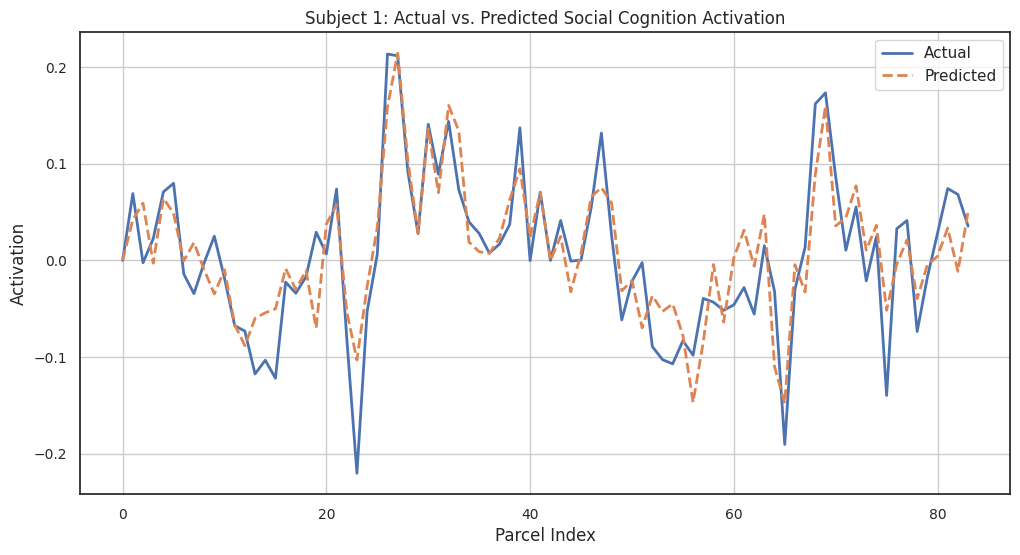

In [19]:
import matplotlib.pyplot as plt

# Choose a subject to visualize
subj_idx = 1

plt.figure(figsize=(12, 6))
plt.plot(activations_social_combined[:, subj_idx], label="Actual", linewidth=2)
plt.plot(predicted_activations_social_combined[:, subj_idx], label="Predicted", linestyle='--', linewidth=2)
plt.title(f"Subject {subj_idx}: Actual vs. Predicted Social Cognition Activation")
plt.xlabel("Parcel Index")
plt.ylabel("Activation")
plt.legend()
plt.grid(True)
plt.show()


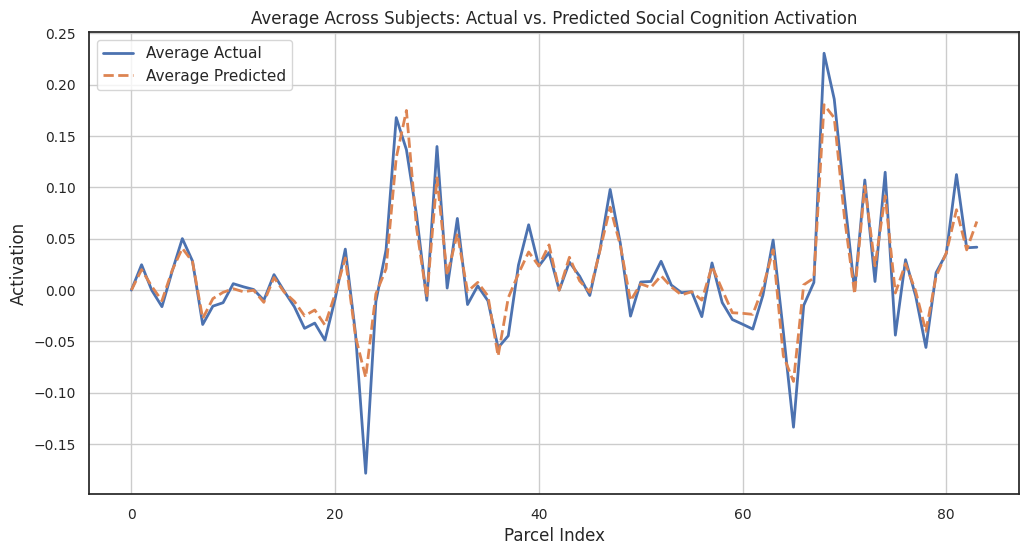

In [20]:
# Average across all subjects
avg_actual = np.mean(activations_social_combined, axis=1)  # Shape: (84,)
avg_predicted = np.mean(predicted_activations_social_combined, axis=1)  # Shape: (84,)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(avg_actual, label="Average Actual", linewidth=2)
plt.plot(avg_predicted, label="Average Predicted", linestyle='--', linewidth=2)
plt.title("Average Across Subjects: Actual vs. Predicted Social Cognition Activation")
plt.xlabel("Parcel Index")
plt.ylabel("Activation")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
from scipy.stats import pearsonr
import numpy as np

subjectwise_correlations_social = []

for subj in range(numsubjs):
    # Check if the predicted and actual activations are not constant
    if np.std(predicted_activations_social_combined[:, subj]) > 0 and np.std(activations_social_combined[:, subj]) > 0:
        r = pearsonr(predicted_activations_social_combined[:, subj], activations_social_combined[:, subj])[0]
        subjectwise_correlations_social.append(r)
    else:
        subjectwise_correlations_social.append(np.nan)  # Use NaN for subjects with constant activations

# Print the average prediction accuracy, excluding NaN values
mean_accuracy = np.nanmean(subjectwise_correlations_social)
print(f"Mean Prediction Accuracy (Social-Mental, Multi-Regression AFM): {mean_accuracy:.3f}")


Mean Prediction Accuracy (Social-Mental, Multi-Regression AFM): 0.854


In [22]:
# Identify and remove subjects with no variance in either actual or predicted activations
subjects_to_remove = []

for subj in range(activations_social_combined.shape[1]):
    if np.std(activations_social_combined[:, subj]) == 0 or np.std(predicted_activations_social_combined[:, subj]) == 0:
        subjects_to_remove.append(subj)

# Remove duplicates
subjects_to_remove = list(set(subjects_to_remove))

print(f"Number of subjects with no variance (either actual or predicted): {len(subjects_to_remove)}")

# Remove these subjects and check for NAN values again.
activations_social_combined_filtered = np.delete(activations_social_combined, subjects_to_remove, axis=1)
predicted_activations_social_combined_filtered = np.delete(predicted_activations_social_combined, subjects_to_remove, axis=1)

if np.isnan(activations_social_combined[:, subj]).any() or np.isnan(predicted_activations_social_combined[:, subj]).any():
  subjects_to_remove.append(subj)

print(f"Filtered activations shape (Actual): {activations_social_combined_filtered.shape}")
print(f"Filtered activations shape (Predicted): {predicted_activations_social_combined_filtered.shape}")


Number of subjects with no variance (either actual or predicted): 45
Filtered activations shape (Actual): (84, 1051)
Filtered activations shape (Predicted): (84, 1051)


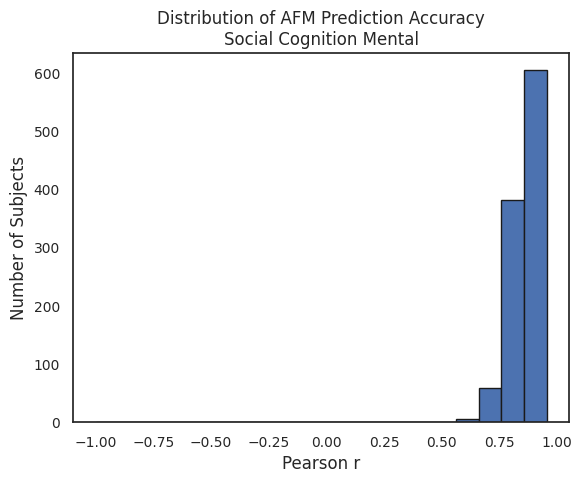

In [23]:
import matplotlib.pyplot as plt

plt.hist(subjectwise_correlations_social, bins=20, edgecolor='k')
plt.title("Distribution of AFM Prediction Accuracy\nSocial Cognition Mental")
plt.xlabel("Pearson r")
plt.ylabel("Number of Subjects")
plt.show()


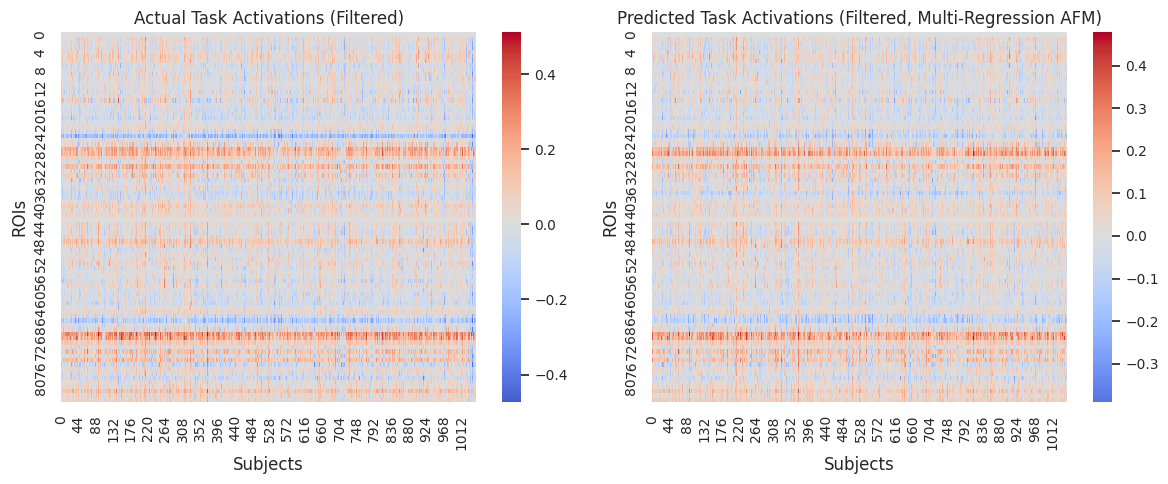

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Heatmap of Actual Activations (Filtered)
plt.subplot(1, 2, 1)
sns.heatmap(activations_social_combined_filtered, cmap="coolwarm", center=0)
plt.title("Actual Task Activations (Filtered)")
plt.xlabel("Subjects")
plt.ylabel("ROIs")

# Heatmap of Predicted Activations (Filtered, Multi-Regression)
plt.subplot(1, 2, 2)
sns.heatmap(predicted_activations_social_combined_filtered, cmap="coolwarm", center=0)
plt.title("Predicted Task Activations (Filtered, Multi-Regression AFM)")
plt.xlabel("Subjects")
plt.ylabel("ROIs")

plt.tight_layout()
plt.show()

This NIfTI file represents the AAL (Automated Anatomical Labeling) atlas in MNI space.
It contains 84 regions of interest (ROIs) and is commonly used in neuroimaging studies to map brain activations to specific anatomical regions.
The AAL atlas can be found through the FieldTrip repository on GitHub:
https://github.com/sandywang/GRETNA/blob/master/Atlas/AAL90_3mm.nii

Created txt file based on labels provided in the following study. Out of 90 total ROIs, 6 subcortical regions were removed for a total of 84 ROIs. Citation below:

Tzourio-Mazoyer, N., Landeau, B., Papathanassiou, D., Crivello, F., Etard, O., Delcroix, N., Mazoyer, B., & Joliot, M. (2002). Automated Anatomical Labeling of activations in SPM using a macroscopic anatomical parcellation of the MNI MRI single-subject brain. NeuroImage, 15(1), 273–289. https://doi.org/10.1006/nimg.2001.0978


In [25]:
import nibabel as nib
import numpy as np
from nilearn import plotting
from nilearn.image import new_img_like
import os

# === Step 1: Define paths ===
drive_path = '/content/drive/MyDrive/AAL_Atlas_MNI_84'
aal_nii_path = os.path.join(drive_path, 'AAL90_3mm.nii')

# === Step 2: Load AAL atlas image ===
aal_img = nib.load(aal_nii_path)
aal_data = aal_img.get_fdata()
affine = aal_img.affine

# === Step 3: Define subcortical label indices to remove ===
# Only removing 6 subcortical regions from AAL90
subcortical_indices = [
    41, 42,  # Amygdala
    37, 38,  # Hippocampus
    73, 74,  # Putamen
    71, 72,  # Caudate
    75, 76,  # Pallidum
    77, 78   # Thalamus
]

# === Step 4: Remove subcortical ROIs ===
aal_data_filtered = np.copy(aal_data)
for idx in subcortical_indices:
    aal_data_filtered[aal_data == idx] = 0  # Set subcortical regions to 0 (remove)

# Save the filtered image with only cortical ROIs
filtered_img = new_img_like(aal_img, aal_data_filtered)
filtered_path = os.path.join(drive_path, 'AAL84_3mm.nii')
filtered_img.to_filename(filtered_path)

print(f"Filtered AAL atlas with 84 ROIs saved to: {filtered_path}")

Filtered AAL atlas with 84 ROIs saved to: /content/drive/MyDrive/AAL_Atlas_MNI_84/AAL84_3mm.nii


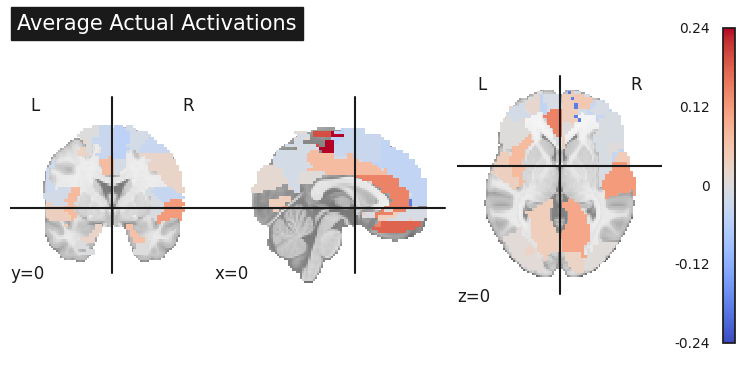

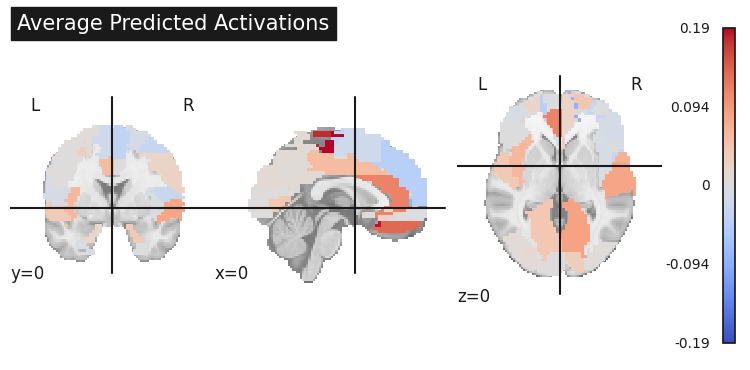

In [26]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting, image

# File paths
aal_file_path = '/content/drive/MyDrive/AAL_Atlas_MNI_84/AAL84_3mm.nii'
roi_labels_path = '/content/drive/MyDrive/AAL_Atlas_MNI_84/AAL_84_ROIs.txt'

# Load the AAL84 NIfTI file (cleaned with 84 ROIs)
aal_img = nib.load(aal_file_path)
aal_data = aal_img.get_fdata()

# Load the region labels
with open(roi_labels_path, 'r') as file:
    region_labels = [line.strip() for line in file.readlines()]

# Assuming activations_social_combined_filtered and predicted_activations_social_combined_filtered
# are already loaded and pre-processed:
# activations_social_combined_filtered: (84, N_subjects)
# predicted_activations_social_combined_filtered: (84, N_subjects)

# Step 1: Average the activations across subjects (mean for each ROI)
avg_activations = np.mean(activations_social_combined_filtered, axis=1)  # Shape: (84,)
avg_predicted_activations = np.mean(predicted_activations_social_combined_filtered, axis=1)  # Shape: (84,)

# Step 2: Create activation maps (use the average activations per ROI)
activation_map = np.zeros_like(aal_data)
predicted_activation_map = np.zeros_like(aal_data)

# Map the average activations onto the respective ROIs in the AAL atlas
for idx, label in enumerate(region_labels):
    # Get the indices corresponding to each ROI
    roi_mask = aal_data == (idx + 1)  # ROI labels in the AAL start from 1
    activation_map[roi_mask] = avg_activations[idx]
    predicted_activation_map[roi_mask] = avg_predicted_activations[idx]

# Step 3: Visualize the activation maps on the brain surface using nilearn

# Save activation map as NIfTI file for visualization
activation_map_img = nib.Nifti1Image(activation_map, aal_img.affine)
predicted_activation_map_img = nib.Nifti1Image(predicted_activation_map, aal_img.affine)

# Step 4: Plot the actual activations on the brain surface with a custom color map (e.g., 'coolwarm')
plotting.plot_stat_map(activation_map_img, title="Average Actual Activations", display_mode='ortho', draw_cross=True, cut_coords=(0, 0, 0), colorbar=True, cmap='coolwarm')

# Step 5: Plot the predicted activations on the brain surface with the same custom color map (e.g., 'coolwarm')
plotting.plot_stat_map(predicted_activation_map_img, title="Average Predicted Activations", display_mode='ortho', draw_cross=True, cut_coords=(0, 0, 0), colorbar=True, cmap='coolwarm')

# Show the plots
plt.show()


Subcortical regions were removed from analysis hence appear greyed out.

#ABIDE Dataset Analysis

## ABIDE Dataset Neurotypical Data

### Preprocessing Steps

In [80]:
# Main collect and download function
def collect_and_download(derivative, pipeline, strategy, out_dir, diagnosis):
    import os
    import urllib.request as request

    # Init variables
    mean_fd_thresh = 0.2
    s3_prefix = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative'
    s3_pheno_path = '/'.join([s3_prefix, 'Phenotypic_V1_0b_preprocessed1.csv'])

    derivative = derivative.lower()
    pipeline = pipeline.lower()
    strategy = strategy.lower()

    # Check derivative for extension
    if 'roi' in derivative:
        extension = '.1D'
    else:
        extension = '.nii.gz'

    if not os.path.exists(out_dir):
        print('Could not find {0}, creating now...'.format(out_dir))
        os.makedirs(out_dir)

    s3_pheno_file = request.urlopen(s3_pheno_path)
    pheno_list = s3_pheno_file.readlines()

    header = pheno_list[0].decode().split(',')
    try:
        site_idx = header.index('SITE_ID')
        file_idx = header.index('FILE_ID')
        age_idx = header.index('AGE_AT_SCAN')
        sex_idx = header.index('SEX')
        dx_idx = header.index('DX_GROUP')
        mean_fd_idx = header.index('func_mean_fd')
    except Exception as exc:
        err_msg = 'Unable to extract header information from the pheno file...'
        raise Exception(err_msg)

    s3_paths = []
    for pheno_row in pheno_list[1:]:
        cs_row = pheno_row.decode().split(',')

        try:
            row_file_id = cs_row[file_idx]
            row_site = cs_row[site_idx]
            row_age = float(cs_row[age_idx])
            row_sex = cs_row[sex_idx]
            row_dx = cs_row[dx_idx]
            row_mean_fd = float(cs_row[mean_fd_idx])
        except Exception as e:
            continue

        if row_file_id == 'no_filename':
            continue
        if row_mean_fd >= mean_fd_thresh:
            continue

        if (diagnosis == 'asd' and row_dx != '1') or (diagnosis == 'tdc' and row_dx != '2'):
            continue

        filename = row_file_id + '_' + derivative + extension
        s3_path = '/'.join([s3_prefix, 'Outputs', pipeline, strategy, derivative, filename])
        s3_paths.append(s3_path)

    total_num_files = len(s3_paths)
    for path_idx, s3_path in enumerate(s3_paths):
        rel_path = s3_path.lstrip(s3_prefix)
        download_file = os.path.join(out_dir, rel_path)
        download_dir = os.path.dirname(download_file)
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            if not os.path.exists(download_file):
                print('Retrieving: {0}'.format(download_file))
                request.urlretrieve(s3_path, download_file)
                print('{0:.3f}% percent complete'.format(100*(float(path_idx+1)/total_num_files)))
            else:
                print('File {0} already exists, skipping...'.format(download_file))
        except Exception as exc:
            print('There was a problem downloading {0}.\n Check input arguments and try again.'.format(s3_path))

    print('Done!')

# pipelines = ["ccs", "cpac", "dparsf", "niak"]
# strategies = ["filt_global", "filt_noglobal", "nofilt_global", "nofilt_noglobal"]
# derivatives = ["alff", "degree_binarize", "degree_weighted", "dual_regression", "eigenvector_binarize", "eigenvector_weighted", "falff", "func_mask", "func_mean", "func_preproc", "lfcd", "reho", "rois_aal", "rois_cc200", "rois_cc400", "rois_dosenbach160", "rois_ez", "rois_ho", "rois_tt", "vmhc"]
# extensions = ["1D", "nii.gz"]

# Variables to specify download settings (modify these values as needed)
desired_derivative = 'rois_aal'  # Derivative of interest (e.g. 'reho')
desired_pipeline = 'cpac'     # Pipeline used to preprocess the data (e.g. 'cpac')
desired_strategy = 'filt_global'  # Noise-removal strategy used during preprocessing
download_data_dir = 'preprocessed_dataset_aal'  # Path to local folder to download files to
desired_diagnosis = 'tdc'  # 'asd', 'tdc', or 'both' corresponding to the diagnosis of the participants for whom data should be downloaded

# Call the collect and download routine
download_data_dir = '/content/drive/MyDrive/preprocessed_dataset_aal'
collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_diagnosis)

File /content/drive/MyDrive/preprocessed_dataset_aal/Outputs/cpac/filt_global/rois_aal/Pitt_0050030_rois_aal.1D already exists, skipping...
File /content/drive/MyDrive/preprocessed_dataset_aal/Outputs/cpac/filt_global/rois_aal/Pitt_0050031_rois_aal.1D already exists, skipping...
File /content/drive/MyDrive/preprocessed_dataset_aal/Outputs/cpac/filt_global/rois_aal/Pitt_0050032_rois_aal.1D already exists, skipping...
File /content/drive/MyDrive/preprocessed_dataset_aal/Outputs/cpac/filt_global/rois_aal/Pitt_0050033_rois_aal.1D already exists, skipping...
File /content/drive/MyDrive/preprocessed_dataset_aal/Outputs/cpac/filt_global/rois_aal/Pitt_0050034_rois_aal.1D already exists, skipping...
File /content/drive/MyDrive/preprocessed_dataset_aal/Outputs/cpac/filt_global/rois_aal/Pitt_0050035_rois_aal.1D already exists, skipping...
File /content/drive/MyDrive/preprocessed_dataset_aal/Outputs/cpac/filt_global/rois_aal/Pitt_0050036_rois_aal.1D already exists, skipping...
File /content/drive/

In [81]:
import os
import numpy as np
import pandas as pd

# Directory containing the .1D files (replace with your path)
data_dir = '/content/drive/MyDrive/preprocessed_dataset_aal'

import glob

# Define the path to the subject data files
data_files = glob.glob('/content/drive/MyDrive/preprocessed_dataset_aal/dataset.zip/Outputs/cpac/filt_global/rois_aal')  # Assuming 1D files for each subject

In [83]:
import numpy as np

# Define the path to a sample subject file (assuming it's the same format for all subjects)
sample_file = '/content/drive/MyDrive/preprocessed_dataset_aal/Outputs/cpac/filt_global/rois_aal/SBL_0051570_rois_aal.1D'

# Load the data from the file
data = np.loadtxt(sample_file)

# Calculate the number of ROIs and number of time points
num_rois = data.shape[1]  # Number of columns = number of ROIs
num_time_points = data.shape[0]  # Number of rows = number of time points

print(f"Number of ROIs: {num_rois}")
print(f"Number of Time Points: {num_time_points}")
print(data.shape)

Number of ROIs: 116
Number of Time Points: 196
(196, 116)


In [85]:
data_files = glob.glob('/content/drive/MyDrive/preprocessed_dataset_aal/Outputs/cpac/filt_global/rois_aal/*.1D')

total_rois = 0
total_time_points = 0
num_files = 0

for file in data_files:
    try:
        # Use pandas for flexibility
        data = pd.read_csv(file, delim_whitespace=True, header=None)
        num_time_points, num_rois = data.shape  # Get dimensions

        total_rois += num_rois
        total_time_points += num_time_points
        num_files += 1  # Only count successfully processed files

    except Exception as e:
        print(f"Error loading {file}: {e}")

if num_files > 0:
    average_rois = total_rois / num_files
    average_time_points = total_time_points / num_files
    print(f"Average number of ROIs: {average_rois}")
    print(f"Average number of time points: {average_time_points}")
else:
    print("No valid files processed.")

<ipython-input-85-88ee098eba39>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-85-88ee098eba39>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-85-88ee098eba39>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-85-88ee098eba39>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-85-88ee098eba39>:10: 

Average number of ROIs: 116.0
Average number of time points: 193.71848739495798


<ipython-input-85-88ee098eba39>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-85-88ee098eba39>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-85-88ee098eba39>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-85-88ee098eba39>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-85-88ee098eba39>:10: 

In [88]:
import numpy as np
import glob

# Path to your AAL parcellation files (adjust accordingly)
data_files = glob.glob('/content/drive/MyDrive/preprocessed_dataset_aal/Outputs/cpac/filt_global/rois_aal/*.1D')

# Initialize list to store time series lengths
time_lengths = []

for file in data_files:
    try:
        data = np.loadtxt(file)  # Shape: (timepoints × ROIs)
        time_lengths.append(data.shape[0])  # Number of timepoints (rows)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Check if we have valid entries
if time_lengths:
    min_timepoints = min(time_lengths)
    max_timepoints = max(time_lengths)
    avg_timepoints = sum(time_lengths) / len(time_lengths)

    print(f"Number of valid subjects: {len(time_lengths)}")
    print(f"Shortest time series: {min_timepoints} timepoints")
    print(f"Longest time series: {max_timepoints} timepoints")
    print(f"Average time series length: {avg_timepoints:.2f} timepoints")
else:
    print("No valid files found.")


Error reading /content/drive/MyDrive/preprocessed_dataset_aal/Outputs/cpac/filt_global/rois_aal/Pitt_0050048_rois_aal.1D: the number of columns changed from 116 to 67 at row 180; use `usecols` to select a subset and avoid this error
Number of valid subjects: 475
Shortest time series: 78 timepoints
Longest time series: 316 timepoints
Average time series length: 192.75 timepoints


In [89]:
# check subjects with ≥180 timepoints
min_time_thresh = 180
short_enough = [t for t in time_lengths if t >= 180]
print(f"Subjects with ≥180 timepoints: {len(short_enough)} / {len(time_lengths)}")

Subjects with ≥180 timepoints: 217 / 475


In [91]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import glob
import os

input_folder = "/content/drive/MyDrive/preprocessed_dataset_aal/Outputs/cpac/filt_global/rois_aal/"
output_folder = "/content/drive/MyDrive/preprocessed_dataset_aal/interpolated_data_new/"
os.makedirs(output_folder, exist_ok=True)

num_rois = 116  # Expected number of ROIs (columns)
target_timepoints = 192  # Desired number of timepoints (rows)

# Interpolation Function
def interpolate_time_series(data, target_length):
    """
    Interpolate each ROI's time series (column) to a fixed number of timepoints.
    Assumes input data is shape: (timepoints × ROIs)
    """
    original_length = data.shape[0]
    original_time = np.arange(original_length)
    new_time = np.linspace(0, original_length - 1, target_length)

    interpolated_data = np.zeros((target_length, data.shape[1]))

    for roi_idx in range(data.shape[1]):
        f = interp1d(original_time, data[:, roi_idx], kind='linear', fill_value='extrapolate')
        interpolated_data[:, roi_idx] = f(new_time)

    return interpolated_data

# Process All Files
data_files = glob.glob(os.path.join(input_folder, "*.1D"))
num_subjects = len(data_files)

restdata = np.zeros((target_timepoints, num_rois, num_subjects))
skipped_files = []
subject_index = 0

for i, file in enumerate(data_files):
    try:
        # Load data as (timepoints × ROIs)
        subj_data = pd.read_csv(file, delim_whitespace=True, header=None, comment='#').values

        # Check if number of ROIs is correct
        if subj_data.shape[1] != num_rois:
            print(f"Skipping {file} due to ROI mismatch: {subj_data.shape}")
            skipped_files.append(file)
            continue

        # Interpolate
        subj_data_interp = interpolate_time_series(subj_data, target_timepoints)

        # Assign to 3D matrix
        restdata[:, :, subject_index] = subj_data_interp
        subject_index += 1

        # Save subject-level data
        subj_filename = os.path.basename(file).replace(".1D", ".npy")
        np.save(os.path.join(output_folder, subj_filename), subj_data_interp)

    except Exception as e:
        print(f"Error processing {file}: {e}")
        skipped_files.append(file)

# Trim unused slots in restdata
restdata = restdata[:, :, :subject_index]

# Save the full 3D matrix
np.save(os.path.join(output_folder, "restdata.npy"), restdata)

print(f"\n Interpolation complete. Saved {subject_index} subjects.")
if skipped_files:
    print(f" Skipped {len(skipped_files)} files due to issues.")


<ipython-input-91-620062cbb80c>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  subj_data = pd.read_csv(file, delim_whitespace=True, header=None, comment='#').values
<ipython-input-91-620062cbb80c>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  subj_data = pd.read_csv(file, delim_whitespace=True, header=None, comment='#').values
<ipython-input-91-620062cbb80c>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  subj_data = pd.read_csv(file, delim_whitespace=True, header=None, comment='#').values
<ipython-input-91-620062cbb80c>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  subj_data = pd.read_cs


 Interpolation complete. Saved 476 subjects.


<ipython-input-92-f3671a9342ec>:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#').values


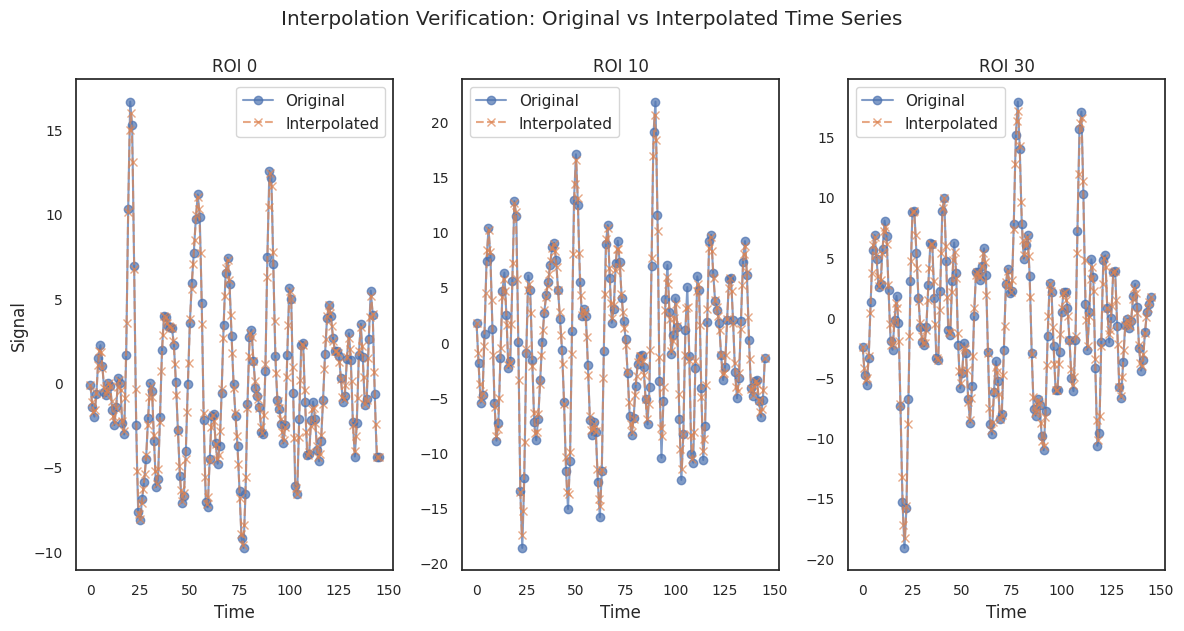

In [92]:
# Verify Interpolated Time Series
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# ===== Configuration =====
file_path = '/content/drive/MyDrive/preprocessed_dataset_aal/Outputs/cpac/filt_global/rois_aal/Caltech_0051493_rois_aal.1D'  # Update to any .1D file
target_timepoints = 192  # Interpolation target
roi_indices_to_plot = [0, 10, 30]  # Pick a few ROIs to visualize

# ===== Load Original Data (Timepoints × ROIs) =====
data = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#').values
original_time = np.arange(data.shape[0])
interpolated_time = np.linspace(0, data.shape[0] - 1, target_timepoints)

# ===== Interpolate Function =====
def interpolate_time_series(data, target_length):
    original_time = np.arange(data.shape[0])
    new_time = np.linspace(0, data.shape[0] - 1, target_length)
    interpolated_data = np.zeros((target_length, data.shape[1]))
    for roi in range(data.shape[1]):
        f = interp1d(original_time, data[:, roi], kind='linear', fill_value='extrapolate')
        interpolated_data[:, roi] = f(new_time)
    return interpolated_data

# ===== Interpolate the Data =====
interpolated_data = interpolate_time_series(data, target_timepoints)

# ===== Plotting for a Few ROIs =====
plt.figure(figsize=(12, 6))
for i, roi in enumerate(roi_indices_to_plot):
    plt.subplot(1, len(roi_indices_to_plot), i + 1)
    plt.plot(original_time, data[:, roi], 'o-', label='Original', alpha=0.7)
    plt.plot(interpolated_time, interpolated_data[:, roi], 'x--', label='Interpolated', alpha=0.7)
    plt.title(f'ROI {roi}')
    plt.xlabel('Time')
    if i == 0:
        plt.ylabel('Signal')
    plt.legend()
    plt.tight_layout()

plt.suptitle("Interpolation Verification: Original vs Interpolated Time Series", y=1.05)
plt.show()


In [93]:
# Correlation between original and interpolated (downsampled to same length)
from scipy.stats import pearsonr
for roi in roi_indices_to_plot:
    r, _ = pearsonr(np.interp(original_time, interpolated_time, interpolated_data[:, roi]), data[:, roi])
    print(f"ROI {roi} correlation between original and interpolated: r = {r:.4f}")


ROI 0 correlation between original and interpolated: r = 0.9983
ROI 10 correlation between original and interpolated: r = 0.9975
ROI 30 correlation between original and interpolated: r = 0.9979


In [94]:
# Determine which ROIs to remove based on labels found in the AAL_84_ROIs.txt file created earlier.

# Load AAL116 data: (timepoints, 116 ROIs, subjects)
data_path = '/content/drive/MyDrive/preprocessed_dataset_aal/interpolated_data_new/restdata.npy'
restdata = np.load(data_path)

# Step 1: Remove cerebellar ROIs (AAL116 indices 89–114, total 26)
cerebellar_indices = np.arange(89, 115)
remaining_indices = np.setdiff1d(np.arange(116), cerebellar_indices)

# Step 2: Remove 6 subcortical ROIs: Caudate, Hippocampus, Amygdala
# unwanted_subcorticals = [70, 71, 78, 79, 80, 81]
unwanted_subcorticals = [70, 71, 36, 37, 40, 41]
final_indices = np.setdiff1d(remaining_indices, unwanted_subcorticals)

# Double-check output length
print(f"Number of ROIs after cleanup: {len(final_indices)}")
assert len(final_indices) == 84, f"Expected 84 ROIs, got {len(final_indices)}"

# Step 3: Slice and reformat → (ROIs, timepoints, subjects)
restdata_aal84 = restdata[:, final_indices, :]
restdata_aal84 = np.transpose(restdata_aal84, (1, 0, 2))  # → (ROIs, timepoints, subjects)

# Save output
np.save('/content/drive/MyDrive/preprocessed_dataset_aal/interpolated_data_new/restdata_aal84.npy', restdata_aal84)

# Confirm
print("Original shape:", restdata.shape)
print("Processed AAL84 shape (ROIs, timepoints, subjects):", restdata_aal84.shape)


Number of ROIs after cleanup: 84
Original shape: (192, 116, 476)
Processed AAL84 shape (ROIs, timepoints, subjects): (84, 192, 476)


In [102]:
#Create new subject files with the updated 84 ROIs.

# Parameters
data_path = '/content/drive/MyDrive/preprocessed_dataset_aal/interpolated_data_new/restdata.npy'
output_dir = '/content/drive/MyDrive/preprocessed_dataset_aal/interpolated_ROI84'  # New folder for processed data
os.makedirs(output_dir, exist_ok=True)

# Load AAL116 data: (timepoints, 116 ROIs, subjects)
restdata = np.load(data_path)

# Step 1: Remove cerebellar ROIs (AAL116 indices 89–114, total 26)(should be 90-115?)
cerebellar_indices = np.arange(90, 116)
remaining_indices = np.setdiff1d(np.arange(116), cerebellar_indices)

# Step 2: Remove 6 subcortical ROIs: Caudate, Hippocampus, Amygdala
# unwanted_subcorticals = [70, 71, 78, 79, 80, 81]
unwanted_subcorticals = [70, 71, 36, 37, 40, 41]
final_indices = np.setdiff1d(remaining_indices, unwanted_subcorticals)

# Double-check output length
print(f"Number of ROIs after cleanup: {len(final_indices)}")
assert len(final_indices) == 84, f"Expected 84 ROIs, got {len(final_indices)}"

# Step 3: Slice and reformat → (ROIs, timepoints, subjects)
restdata_aal84 = restdata[:, final_indices, :]  # Keep only the final 84 ROIs

# Transpose data to (ROIs, timepoints, subjects)
restdata_aal84 = np.transpose(restdata_aal84, (1, 0, 2))

# Step 4: Save each subject's data in a new file under the 'interpolated_ROI84' folder
for subject_idx in range(restdata_aal84.shape[2]):
    # Extract subject data
    subject_data = restdata_aal84[:, :, subject_idx]  # Shape: (84 ROIs, timepoints)

    # Create a new filename for the subject
    subject_id = f"subject_{subject_idx + 1}"  # Naming convention for subject files
    output_file_path = os.path.join(output_dir, f"{subject_id}_aal84.npy")

    # Save subject's data
    np.save(output_file_path, subject_data)

    print(f"Subject {subject_id} processed and saved as {output_file_path}")

# Confirm processed data shapes
print(f"Original shape: {restdata.shape}")
print(f"Processed AAL84 shape (ROIs, timepoints, subjects): {restdata_aal84.shape}")


Number of ROIs after cleanup: 84
Subject subject_1 processed and saved as /content/drive/MyDrive/preprocessed_dataset_aal/interpolated_ROI84/subject_1_aal84.npy
Subject subject_2 processed and saved as /content/drive/MyDrive/preprocessed_dataset_aal/interpolated_ROI84/subject_2_aal84.npy
Subject subject_3 processed and saved as /content/drive/MyDrive/preprocessed_dataset_aal/interpolated_ROI84/subject_3_aal84.npy
Subject subject_4 processed and saved as /content/drive/MyDrive/preprocessed_dataset_aal/interpolated_ROI84/subject_4_aal84.npy
Subject subject_5 processed and saved as /content/drive/MyDrive/preprocessed_dataset_aal/interpolated_ROI84/subject_5_aal84.npy
Subject subject_6 processed and saved as /content/drive/MyDrive/preprocessed_dataset_aal/interpolated_ROI84/subject_6_aal84.npy
Subject subject_7 processed and saved as /content/drive/MyDrive/preprocessed_dataset_aal/interpolated_ROI84/subject_7_aal84.npy
Subject subject_8 processed and saved as /content/drive/MyDrive/preproc

### Multiple-Regression FC

In [103]:
# Parameters for AAL dataset
N_ROIS_AAL = 84  # Number of ROIs in AAL90
N_TIMEPOINTS = 192  # Adjust based on your dataset
aal_data_dir = '/content/drive/MyDrive/preprocessed_dataset_aal/interpolated_ROI84'  # Path to your AAL data
file_paths = glob.glob(os.path.join(aal_data_dir, '*.npy'))

# Initialize lists to store data and subject IDs
restdata_list = []
selected_subject_ids = []  # Stores extracted subject IDs

for file_path in file_paths:
    filename = os.path.basename(file_path)

    # Extract subject ID (everything before '_rois')
    subject_id_cleaned = filename.split('_rois')[0]  # This will extract "Pitt_0050003"

    try:
        data = np.load(file_path)

        # Ensure the data shape matches AAL90: (N_ROIS_AAL, N_TIMEPOINTS)
        if data.shape != (N_ROIS_AAL, N_TIMEPOINTS):
            print(f"Skipping subject {subject_id_cleaned} - unexpected shape {data.shape}")
            continue

        restdata_list.append(data)
        selected_subject_ids.append(subject_id_cleaned)  # Store extracted ID
    except Exception as e:
        print(f"Error loading subject {subject_id_cleaned}: {e}")

# Convert list to numpy array if data exists
if restdata_list:
    restdata_aal = np.stack(restdata_list, axis=2)  # Shape: (N_ROIS_AAL, N_TIMEPOINTS, N_SUBJECTS)
    print(f"AAL Restdata Loaded Successfully!")
    print(f"AAL Restdata Shape: {restdata_aal.shape}")
else:
    print("No valid .npy files were loaded.")

# Summary of selected subjects
if selected_subject_ids:
    print("Summary of Selected Subjects:")
    print(f"Total subjects loaded: {len(selected_subject_ids)}")
    print("Subject IDs:", ", ".join(selected_subject_ids))


AAL Restdata Loaded Successfully!
AAL Restdata Shape: (84, 192, 476)
Summary of Selected Subjects:
Total subjects loaded: 476
Subject IDs: subject_1_aal84.npy, subject_2_aal84.npy, subject_3_aal84.npy, subject_4_aal84.npy, subject_5_aal84.npy, subject_6_aal84.npy, subject_7_aal84.npy, subject_8_aal84.npy, subject_9_aal84.npy, subject_10_aal84.npy, subject_11_aal84.npy, subject_12_aal84.npy, subject_13_aal84.npy, subject_14_aal84.npy, subject_15_aal84.npy, subject_16_aal84.npy, subject_17_aal84.npy, subject_18_aal84.npy, subject_19_aal84.npy, subject_20_aal84.npy, subject_21_aal84.npy, subject_22_aal84.npy, subject_23_aal84.npy, subject_24_aal84.npy, subject_25_aal84.npy, subject_26_aal84.npy, subject_27_aal84.npy, subject_28_aal84.npy, subject_29_aal84.npy, subject_30_aal84.npy, subject_31_aal84.npy, subject_32_aal84.npy, subject_33_aal84.npy, subject_34_aal84.npy, subject_35_aal84.npy, subject_36_aal84.npy, subject_37_aal84.npy, subject_38_aal84.npy, subject_39_aal84.npy, subject_40_a

In [104]:
%%time
# Step 0: Load your preprocessed resting-state data
# restdata_aal84 should have shape (84, timepoints, N_subjects)
numnodes_abide = restdata_aal84.shape[0]
numsubjs_abide = restdata_aal84.shape[2]

# Step 1: Compute Multi-Regression FC (84x84xN)
restFC_mreg_abide = np.zeros((numnodes_abide, numnodes_abide, numsubjs_abide), dtype=np.float64)

for subj in range(numsubjs_abide):
    subject_ts = restdata_aal84[:, :, subj]  # (84, timepoints)
    restFC_mreg_abide[:, :, subj] = actflow.connectivity_estimation.multregconn(subject_ts)

print("ABIDE Multi-Regression FC computed")
print("Shape:", restFC_mreg_abide.shape)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [99]:
# Step 1: Get SOCIAL_MENTAL task indices
social_mental_task_indices = [16, 18]

# Step 2: Average SOCIAL_MENTAL task activations across the two conditions and across all subjects
# Result: A single average activation vector (84,) to be applied to all ABIDE subjects
activations_social_combined_avg = np.mean(
    activations_bycond[:, social_mental_task_indices, :], axis=(1, 2)
)  # Shape: (84,)

# Step 3: Predict ABIDE activations using FC matrices and shared activation vector
predicted_activations_social_combined_abide = np.zeros((84, restFC_mreg_abide.shape[2]))

for subj in range(restFC_mreg_abide.shape[2]):
    fc = restFC_mreg_abide[:, :, subj]               # Shape: (84, 84)
    predicted = fc @ activations_social_combined_avg  # (84,)
    predicted_activations_social_combined_abide[:, subj] = predicted

print("Predicted activations shape:", predicted_activations_social_combined_abide.shape)


Predicted activations shape: (84, 476)


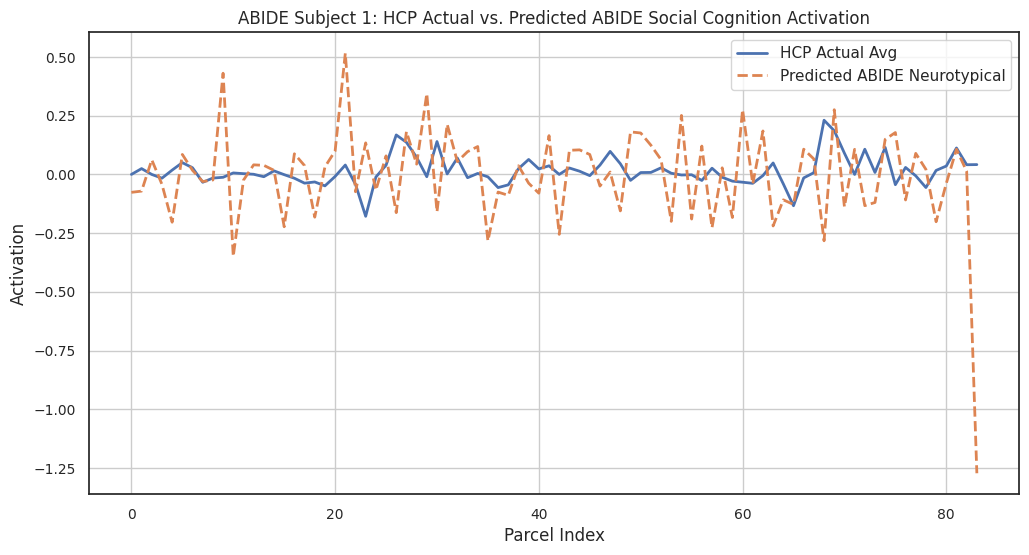

In [100]:
import matplotlib.pyplot as plt

# Choose a subject to visualize (ABIDE subject)
subj_idx = 1

plt.figure(figsize=(12, 6))
plt.plot(activations_social_combined_avg, label="HCP Actual Avg", linewidth=2)
plt.plot(predicted_activations_social_combined_abide[:, subj_idx], label="Predicted ABIDE Neurotypical", linestyle='--', linewidth=2)
plt.title(f"ABIDE Subject {subj_idx}: HCP Actual vs. Predicted ABIDE Social Cognition Activation")
plt.xlabel("Parcel Index")
plt.ylabel("Activation")
plt.legend()
plt.grid(True)
plt.show()


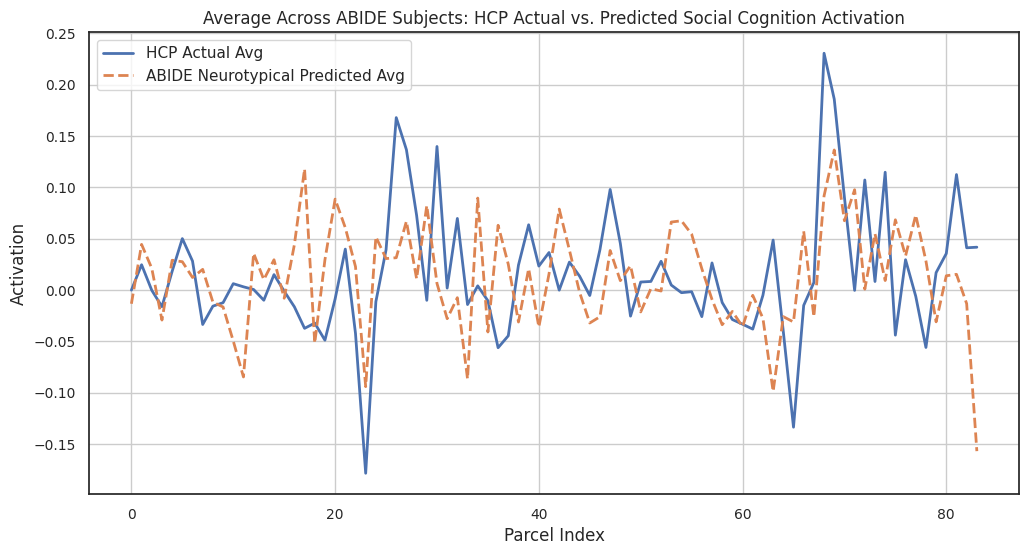

In [ ]:
# Average predicted activations across ABIDE subjects
avg_predicted_abide = np.mean(predicted_activations_social_combined_abide, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(activations_social_combined_avg, label="HCP Actual Avg", linewidth=2)
plt.plot(avg_predicted_abide, label="ABIDE Neurotypical Predicted Avg", linestyle='--', linewidth=2)
plt.title("Average Across ABIDE Subjects: HCP Actual vs. Predicted Social Cognition Activation")
plt.xlabel("Parcel Index")
plt.ylabel("Activation")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from scipy.stats import pearsonr
import numpy as np

subjectwise_correlations_abide = []

for subj in range(predicted_activations_social_combined_abide.shape[1]):
    predicted = predicted_activations_social_combined_abide[:, subj]
    actual = activations_social_combined_avg
    if np.std(predicted) > 0 and np.std(actual) > 0:
        r = pearsonr(predicted, actual)[0]
        subjectwise_correlations_abide.append(r)
    else:
        subjectwise_correlations_abide.append(np.nan)

mean_accuracy_abide = np.nanmean(subjectwise_correlations_abide)
print(f"Mean Prediction Accuracy (Social-Mental, Simple AFM): {mean_accuracy_abide:.3f}")


Mean Prediction Accuracy (Social-Mental, Simple AFM): 0.093


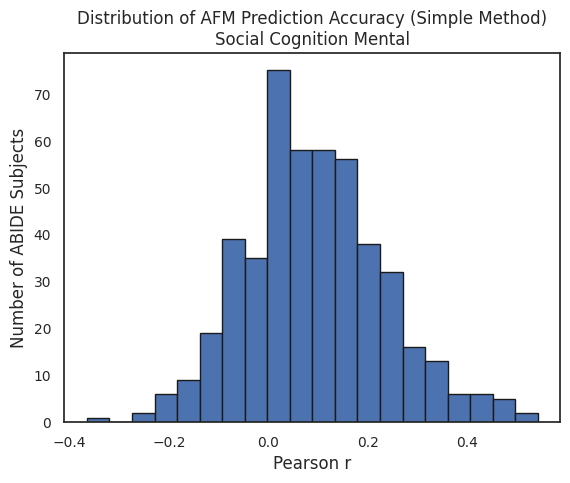

In [ ]:
plt.hist(subjectwise_correlations_abide, bins=20, edgecolor='k')
plt.title("Distribution of AFM Prediction Accuracy (Simple Method)\nSocial Cognition Mental")
plt.xlabel("Pearson r")
plt.ylabel("Number of ABIDE Subjects")
plt.show()


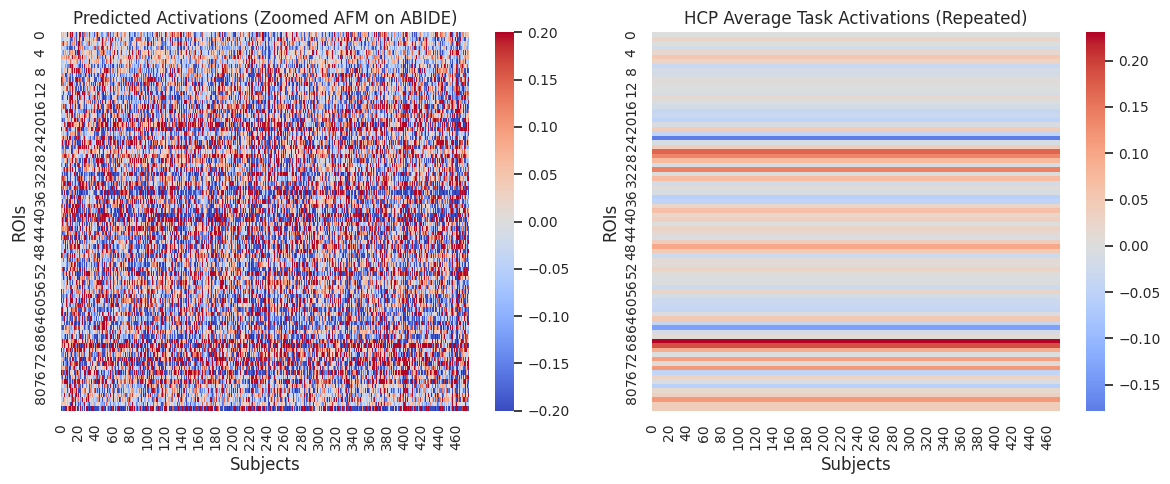

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Heatmap of Predicted Activations (ABIDE) - zoomed scale
plt.subplot(1, 2, 1)
sns.heatmap(predicted_activations_social_combined_abide, cmap="coolwarm", center=0, vmin=-0.2, vmax=0.2)
plt.title("Predicted Activations (Zoomed AFM on ABIDE)")
plt.xlabel("Subjects")
plt.ylabel("ROIs")

# HCP activation (repeated across ABIDE subjects for comparison)
hcp_actual_repeated = np.tile(activations_social_combined_avg[:, np.newaxis], (1, predicted_activations_social_combined_abide.shape[1]))

plt.subplot(1, 2, 2)
sns.heatmap(hcp_actual_repeated, cmap="coolwarm", center=0)
plt.title("HCP Average Task Activations (Repeated)")
plt.xlabel("Subjects")
plt.ylabel("ROIs")

plt.tight_layout()
plt.show()


<ipython-input-121-d15bea47a4b9>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


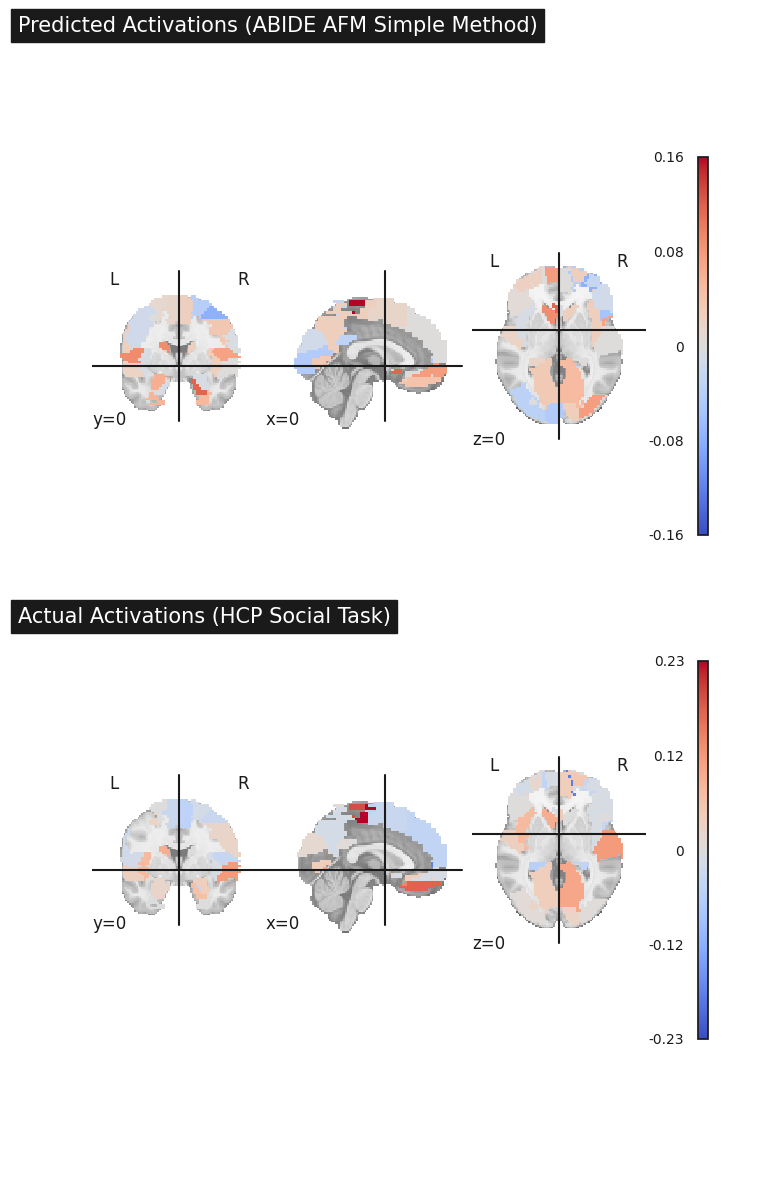

In [ ]:
import nibabel as nib
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt

# === Step 1: Average predicted and actual activations across subjects ===

avg_predicted_activation = np.mean(predicted_activations_social_combined_abide, axis=1)  # Shape: (84,)
avg_actual_activation = activations_social_combined_avg  # Shape: (84,)

# === Step 2: Map averaged activations to brain volume ===
predicted_activation_map = np.zeros_like(aal_data)
actual_activation_map = np.zeros_like(aal_data)

for idx, label in enumerate(region_labels):
    roi_mask = aal_data == (idx + 1)  # AAL is 1-indexed
    predicted_activation_map[roi_mask] = avg_predicted_activation[idx]
    actual_activation_map[roi_mask] = avg_actual_activation[idx]

# === Step 3: Convert to NIfTI images ===
predicted_img = nib.Nifti1Image(predicted_activation_map, aal_img.affine)
actual_img = nib.Nifti1Image(actual_activation_map, aal_img.affine)

# === Step 4: Plot vertically ===
fig, axes = plt.subplots(2, 1, figsize=(8, 12))  # 2 rows, 1 column

# Top: Predicted
display_pred = plotting.plot_stat_map(
    predicted_img,
    title="Predicted Activations (ABIDE AFM Simple Method)",
    display_mode='ortho',
    draw_cross=True,
    cut_coords=(0, 0, 0),
    colorbar=True,
    cmap='coolwarm',
    axes=axes[0]
)

# Bottom: Actual
display_actual = plotting.plot_stat_map(
    actual_img,
    title="Actual Activations (HCP Social Task)",
    display_mode='ortho',
    draw_cross=True,
    cut_coords=(0, 0, 0),
    colorbar=True,
    cmap='coolwarm',
    axes=axes[1]
)

plt.tight_layout()
plt.show()


### Alternate Method - Transfer Learning

In [28]:
#1. Learn a linear model on HCP data.

from sklearn.linear_model import Ridge
import numpy as np

# Get HCP data
X_hcp = np.transpose(restFC_mreg, (2, 0, 1))  # Shape: (N_subjects, 84, 84)
Y_hcp = np.transpose(activations_social_combined, (1, 0))  # Shape: (N_subjects, 84)

num_rois = X_hcp.shape[1]
hcp_weights = np.zeros((num_rois, num_rois))

# Train ridge regression model for each ROI using other ROIs' FC profiles
for roi in range(num_rois):
    X_roi = X_hcp[:, roi, :]  # Features: FC profile of ROI across subjects
    y_roi = Y_hcp[:, roi]     # Target: activation of this ROI across subjects

    model = Ridge(alpha=1.0)
    model.fit(X_roi, y_roi)
    hcp_weights[roi, :] = model.coef_


In [29]:
#2. Apply learned model to ABIDE Neurotypical data.
# Apply HCP-learned weights to ABIDE FC matrices
X_abide = np.transpose(restFC_mreg_abide, (2, 0, 1))  # Shape: (N_abide, 84, 84)
Y_abide_predicted = np.zeros((num_rois, X_abide.shape[0]))

for subj in range(X_abide.shape[0]):
    for roi in range(num_rois):
        Y_abide_predicted[roi, subj] = np.dot(hcp_weights[roi, :], X_abide[subj, roi, :])


NameError: name 'restFC_mreg_abide' is not defined

In [30]:
import matplotlib.pyplot as plt

# Choose a subject to visualize (ABIDE subject)
subj_idx = 268

plt.figure(figsize=(12, 6))
plt.plot(activations_social_combined_avg, label="HCP Actual Avg", linewidth=2)
plt.plot(Y_abide_predicted[:, subj_idx], label="Predicted ABIDE Neurotypical", linestyle='--', linewidth=2)
plt.title(f"ABIDE Subject {subj_idx}: HCP Actual vs. Predicted ABIDE Social Cognition Activation")
plt.xlabel("Parcel Index")
plt.ylabel("Activation")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'activations_social_combined_avg' is not defined

<Figure size 1200x600 with 0 Axes>

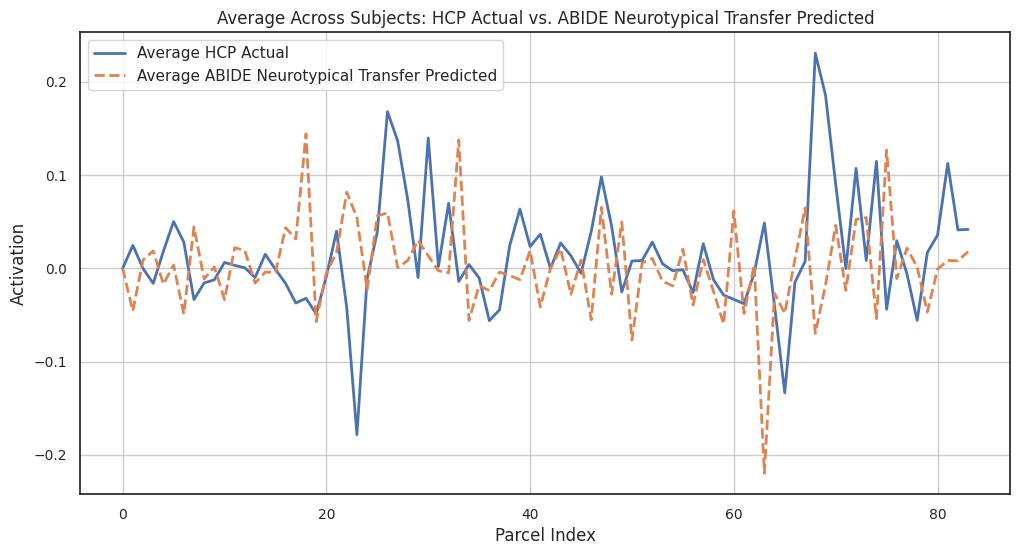

In [ ]:
# Average across all HCP subjects
avg_actual_hcp = np.mean(activations_social_combined, axis=1)
# Average across all ABIDE predicted
avg_predicted_abide = np.mean(Y_abide_predicted, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(avg_actual_hcp, label="Average HCP Actual", linewidth=2)
plt.plot(avg_predicted_abide, label="Average ABIDE Neurotypical Transfer Predicted", linestyle='--', linewidth=2)
plt.title("Average Across Subjects: HCP Actual vs. ABIDE Neurotypical Transfer Predicted")
plt.xlabel("Parcel Index")
plt.ylabel("Activation")
plt.legend()
plt.grid(True)
plt.show()


Mean Prediction Accuracy (Social-Mental, Simple AFM): 0.034


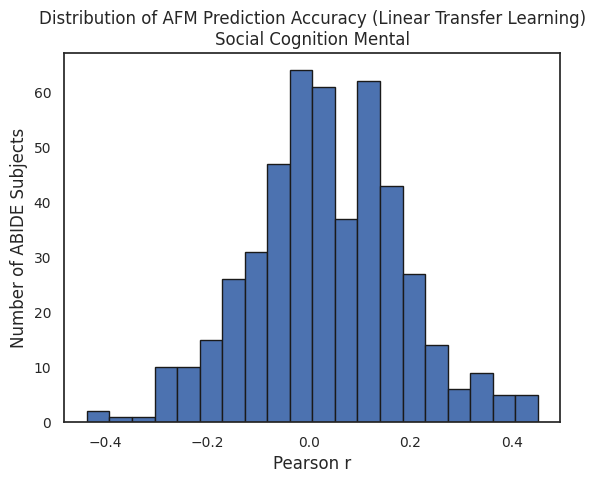

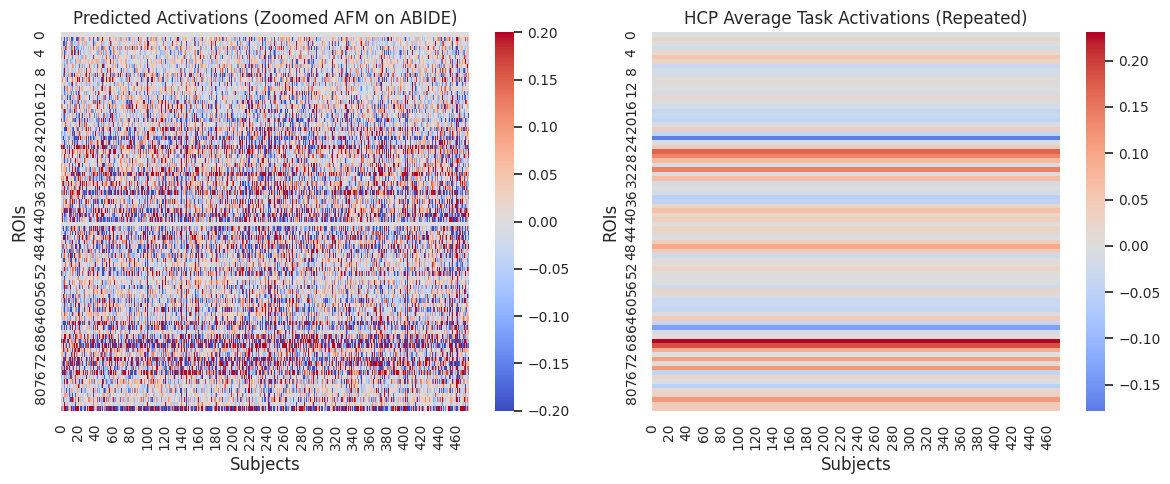

In [ ]:
# Calculate Pearson correlation for each subject (ABIDE)
subjectwise_correlations_abide = []

for subj in range(Y_abide_predicted.shape[1]):
    predicted = Y_abide_predicted[:, subj]
    actual = activations_social_combined_avg
    if np.std(predicted) > 0 and np.std(actual) > 0:
        r = pearsonr(predicted, actual)[0]
        subjectwise_correlations_abide.append(r)
    else:
        subjectwise_correlations_abide.append(np.nan)

# Calculate mean prediction accuracy across ABIDE subjects
mean_accuracy_abide = np.nanmean(subjectwise_correlations_abide)
print(f"Mean Prediction Accuracy (Social-Mental, Simple AFM): {mean_accuracy_abide:.3f}")

# Plot histogram of prediction accuracies (Pearson r)
plt.hist(subjectwise_correlations_abide, bins=20, edgecolor='k')
plt.title("Distribution of AFM Prediction Accuracy (Linear Transfer Learning)\nSocial Cognition Mental")
plt.xlabel("Pearson r")
plt.ylabel("Number of ABIDE Subjects")
plt.show()

# Heatmap of Predicted Activations (ABIDE) - zoomed scale
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(Y_abide_predicted, cmap="coolwarm", center=0, vmin=-0.2, vmax=0.2)
plt.title("Predicted Activations (Zoomed AFM on ABIDE)")
plt.xlabel("Subjects")
plt.ylabel("ROIs")

# HCP activation (repeated across ABIDE subjects for comparison)
hcp_actual_repeated = np.tile(activations_social_combined_avg[:, np.newaxis], (1, Y_abide_predicted.shape[1]))

plt.subplot(1, 2, 2)
sns.heatmap(hcp_actual_repeated, cmap="coolwarm", center=0)
plt.title("HCP Average Task Activations (Repeated)")
plt.xlabel("Subjects")
plt.ylabel("ROIs")

plt.tight_layout()
plt.show()


Prediction accuracy is quite poor using both methods. The simple prediction method has a slightly increased correlation than the linear transfer learning method.

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

# === Step 1: Average HCP activations across subjects ===
avg_predicted_abide_neurotypical = np.mean(Y_abide_predicted, axis=1)                        # shape: (84,)

# === Step 2: Map average activations to brain volume ===
activation_map = np.zeros_like(aal_data)
predicted_activation_map = np.zeros_like(aal_data)

for idx, label in enumerate(region_labels):
    roi_mask = aal_data == (idx + 1)
    activation_map[roi_mask] = avg_activations[idx]
    predicted_activation_map[roi_mask] = avg_predicted_abide_neurotypical[idx]

# === Step 3: Convert to NIfTI images ===
activation_img = nib.Nifti1Image(activation_map, aal_img.affine)
predicted_img = nib.Nifti1Image(predicted_activation_map, aal_img.affine)

# === Step 4: Plot actual vs predicted maps ===
plotting.plot_stat_map(
    activation_img,
    title="HCP: Average Actual Activations",
    display_mode='ortho',
    draw_cross=True,
    cut_coords=(0, 0, 0),
    colorbar=True,
    cmap='coolwarm'
)

plotting.plot_stat_map(
    predicted_img,
    title="ABIDE: Average Predicted Activations (Transfer)",
    display_mode='ortho',
    draw_cross=True,
    cut_coords=(0, 0, 0),
    colorbar=True,
    cmap='coolwarm'
)

plt.show()


NameError: name 'Y_abide_predicted' is not defined

## ABIDE ASD Data
### Preprocessing Steps

In [31]:
# Main collect and download function
def collect_and_download(derivative, pipeline, strategy, out_dir, diagnosis):
    import os
    import urllib.request as request

    # Init variables
    mean_fd_thresh = 0.2
    s3_prefix = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative'
    s3_pheno_path = '/'.join([s3_prefix, 'Phenotypic_V1_0b_preprocessed1.csv'])

    derivative = derivative.lower()
    pipeline = pipeline.lower()
    strategy = strategy.lower()

    # Check derivative for extension
    if 'roi' in derivative:
        extension = '.1D'
    else:
        extension = '.nii.gz'

    if not os.path.exists(out_dir):
        print('Could not find {0}, creating now...'.format(out_dir))
        os.makedirs(out_dir)

    s3_pheno_file = request.urlopen(s3_pheno_path)
    pheno_list = s3_pheno_file.readlines()

    header = pheno_list[0].decode().split(',')
    try:
        site_idx = header.index('SITE_ID')
        file_idx = header.index('FILE_ID')
        age_idx = header.index('AGE_AT_SCAN')
        sex_idx = header.index('SEX')
        dx_idx = header.index('DX_GROUP')
        mean_fd_idx = header.index('func_mean_fd')
    except Exception as exc:
        err_msg = 'Unable to extract header information from the pheno file...'
        raise Exception(err_msg)

    s3_paths = []
    for pheno_row in pheno_list[1:]:
        cs_row = pheno_row.decode().split(',')

        try:
            row_file_id = cs_row[file_idx]
            row_site = cs_row[site_idx]
            row_age = float(cs_row[age_idx])
            row_sex = cs_row[sex_idx]
            row_dx = cs_row[dx_idx]
            row_mean_fd = float(cs_row[mean_fd_idx])
        except Exception as e:
            continue

        if row_file_id == 'no_filename':
            continue
        if row_mean_fd >= mean_fd_thresh:
            continue

        if (diagnosis == 'asd' and row_dx != '1') or (diagnosis == 'tdc' and row_dx != '2'):
            continue

        filename = row_file_id + '_' + derivative + extension
        s3_path = '/'.join([s3_prefix, 'Outputs', pipeline, strategy, derivative, filename])
        s3_paths.append(s3_path)

    total_num_files = len(s3_paths)
    for path_idx, s3_path in enumerate(s3_paths):
        rel_path = s3_path.lstrip(s3_prefix)
        download_file = os.path.join(out_dir, rel_path)
        download_dir = os.path.dirname(download_file)
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            if not os.path.exists(download_file):
                print('Retrieving: {0}'.format(download_file))
                request.urlretrieve(s3_path, download_file)
                print('{0:.3f}% percent complete'.format(100*(float(path_idx+1)/total_num_files)))
            else:
                print('File {0} already exists, skipping...'.format(download_file))
        except Exception as exc:
            print('There was a problem downloading {0}.\n Check input arguments and try again.'.format(s3_path))

    print('Done!')

# pipelines = ["ccs", "cpac", "dparsf", "niak"]
# strategies = ["filt_global", "filt_noglobal", "nofilt_global", "nofilt_noglobal"]
# derivatives = ["alff", "degree_binarize", "degree_weighted", "dual_regression", "eigenvector_binarize", "eigenvector_weighted", "falff", "func_mask", "func_mean", "func_preproc", "lfcd", "reho", "rois_aal", "rois_cc200", "rois_cc400", "rois_dosenbach160", "rois_ez", "rois_ho", "rois_tt", "vmhc"]
# extensions = ["1D", "nii.gz"]

# Variables to specify download settings (modify these values as needed)
desired_derivative = 'rois_aal'  # Derivative of interest (e.g. 'reho')
desired_pipeline = 'cpac'     # Pipeline used to preprocess the data (e.g. 'cpac')
desired_strategy = 'filt_global'  # Noise-removal strategy used during preprocessing
download_data_dir = 'preprocessed_dataset_aal'  # Path to local folder to download files to
desired_diagnosis = 'asd'  # 'asd', 'tdc', or 'both' corresponding to the diagnosis of the participants for whom data should be downloaded

# Call the collect and download routine
download_data_dir = '/content/drive/MyDrive/preprocessed_dataset_asd'
collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_diagnosis)

File /content/drive/MyDrive/preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_aal/Pitt_0050004_rois_aal.1D already exists, skipping...
File /content/drive/MyDrive/preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_aal/Pitt_0050005_rois_aal.1D already exists, skipping...
File /content/drive/MyDrive/preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_aal/Pitt_0050006_rois_aal.1D already exists, skipping...
File /content/drive/MyDrive/preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_aal/Pitt_0050007_rois_aal.1D already exists, skipping...
File /content/drive/MyDrive/preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_aal/Pitt_0050008_rois_aal.1D already exists, skipping...
File /content/drive/MyDrive/preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_aal/Pitt_0050009_rois_aal.1D already exists, skipping...
File /content/drive/MyDrive/preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_aal/Pitt_0050010_rois_aal.1D already exists, skipping...
File /content/drive/

In [32]:
import os
import numpy as np
import pandas as pd

# Directory containing the .1D files (replace with your path)
data_dir = '/content/drive/MyDrive/preprocessed_dataset_asd'

import glob

# Define the path to the subject data files
data_files = glob.glob('/content/drive/MyDrive/preprocessed_dataset_asd/dataset.zip/Outputs/cpac/filt_global/rois_aal')  # Assuming 1D files for each subject

import numpy as np

# Define the path to a sample subject file (assuming it's the same format for all subjects)
sample_file = '/content/drive/MyDrive/preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_aal/SBL_0051580_rois_aal.1D'

# Load the data from the file
data = np.loadtxt(sample_file)

# Calculate the number of ROIs and number of time points
num_rois = data.shape[1]  # Number of columns = number of ROIs
num_time_points = data.shape[0]  # Number of rows = number of time points

print(f"Number of ROIs: {num_rois}")
print(f"Number of Time Points: {num_time_points}")
print(data.shape)

Number of ROIs: 116
Number of Time Points: 196
(196, 116)


In [33]:
data_files = glob.glob('/content/drive/MyDrive/preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_aal/*.1D')

total_rois = 0
total_time_points = 0
num_files = 0

for file in data_files:
    try:
        # Use pandas for flexibility
        data = pd.read_csv(file, delim_whitespace=True, header=None)
        num_time_points, num_rois = data.shape  # Get dimensions

        total_rois += num_rois
        total_time_points += num_time_points
        num_files += 1  # Only count successfully processed files

    except Exception as e:
        print(f"Error loading {file}: {e}")

if num_files > 0:
    average_rois = total_rois / num_files
    average_time_points = total_time_points / num_files
    print(f"Average number of ROIs: {average_rois}")
    print(f"Average number of time points: {average_time_points}")
else:
    print("No valid files processed.")

<ipython-input-33-2dab07421b35>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-33-2dab07421b35>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-33-2dab07421b35>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-33-2dab07421b35>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-33-2dab07421b35>:10: 

Average number of ROIs: 116.0
Average number of time points: 192.5563725490196


<ipython-input-33-2dab07421b35>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-33-2dab07421b35>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-33-2dab07421b35>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-33-2dab07421b35>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file, delim_whitespace=True, header=None)
<ipython-input-33-2dab07421b35>:10: 

In [34]:
# Initialize list to store time series lengths
time_lengths = []

for file in data_files:
    try:
        data = np.loadtxt(file)  # Shape: (timepoints × ROIs)
        time_lengths.append(data.shape[0])  # Number of timepoints (rows)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Check if we have valid entries
if time_lengths:
    min_timepoints = min(time_lengths)
    max_timepoints = max(time_lengths)
    avg_timepoints = sum(time_lengths) / len(time_lengths)

    print(f"Number of valid subjects: {len(time_lengths)}")
    print(f"Shortest time series: {min_timepoints} timepoints")
    print(f"Longest time series: {max_timepoints} timepoints")
    print(f"Average time series length: {avg_timepoints:.2f} timepoints")
else:
    print("No valid files found.")

# check subjects with ≥180 timepoints
min_time_thresh = 180
short_enough = [t for t in time_lengths if t >= 180]
print(f"Subjects with ≥180 timepoints: {len(short_enough)} / {len(time_lengths)}")

Number of valid subjects: 408
Shortest time series: 78 timepoints
Longest time series: 316 timepoints
Average time series length: 191.56 timepoints
Subjects with ≥180 timepoints: 195 / 408


In [35]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import glob
import os

input_folder = "/content/drive/MyDrive/preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_aal"
output_folder = "/content/drive/MyDrive/preprocessed_dataset_asd/interpolated_asd"
os.makedirs(output_folder, exist_ok=True)

num_rois = 116  # Expected number of ROIs (columns)
target_timepoints = 192  # Desired number of timepoints (rows)

# Interpolation Function
def interpolate_time_series(data, target_length):
    """
    Interpolate each ROI's time series (column) to a fixed number of timepoints.
    Assumes input data is shape: (timepoints × ROIs)
    """
    original_length = data.shape[0]
    original_time = np.arange(original_length)
    new_time = np.linspace(0, original_length - 1, target_length)

    interpolated_data = np.zeros((target_length, data.shape[1]))

    for roi_idx in range(data.shape[1]):
        f = interp1d(original_time, data[:, roi_idx], kind='linear', fill_value='extrapolate')
        interpolated_data[:, roi_idx] = f(new_time)

    return interpolated_data

# Process All Files
data_files = glob.glob(os.path.join(input_folder, "*.1D"))
num_subjects = len(data_files)

restdata = np.zeros((target_timepoints, num_rois, num_subjects))
skipped_files = []
subject_index = 0

for i, file in enumerate(data_files):
    try:
        # Load data as (timepoints × ROIs)
        subj_data = pd.read_csv(file, delim_whitespace=True, header=None, comment='#').values

        # Check if number of ROIs is correct
        if subj_data.shape[1] != num_rois:
            print(f"Skipping {file} due to ROI mismatch: {subj_data.shape}")
            skipped_files.append(file)
            continue

        # Interpolate
        subj_data_interp = interpolate_time_series(subj_data, target_timepoints)

        # Assign to 3D matrix
        restdata[:, :, subject_index] = subj_data_interp
        subject_index += 1

        # Save subject-level data
        subj_filename = os.path.basename(file).replace(".1D", ".npy")
        np.save(os.path.join(output_folder, subj_filename), subj_data_interp)

    except Exception as e:
        print(f"Error processing {file}: {e}")
        skipped_files.append(file)

# Trim unused slots in restdata
restdata = restdata[:, :, :subject_index]

# Save the full 3D matrix
np.save(os.path.join(output_folder, "restdata.npy"), restdata)

print(f"\n Interpolation complete. Saved {subject_index} subjects.")
if skipped_files:
    print(f" Skipped {len(skipped_files)} files due to issues.")


<ipython-input-35-217710be6613>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  subj_data = pd.read_csv(file, delim_whitespace=True, header=None, comment='#').values
<ipython-input-35-217710be6613>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  subj_data = pd.read_csv(file, delim_whitespace=True, header=None, comment='#').values
<ipython-input-35-217710be6613>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  subj_data = pd.read_csv(file, delim_whitespace=True, header=None, comment='#').values
<ipython-input-35-217710be6613>:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  subj_data = pd.read_cs


 Interpolation complete. Saved 408 subjects.


<ipython-input-36-966c816aec5a>:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#').values


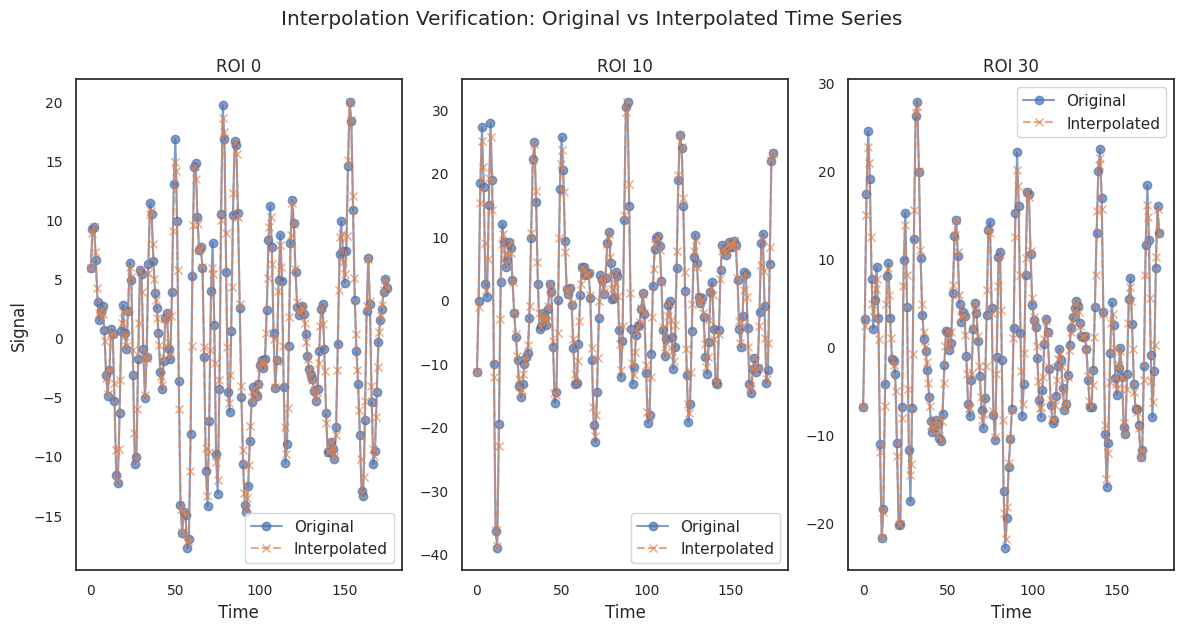

In [36]:
# Verify Interpolated Time Series
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# ===== Configuration =====
file_path = '/content/drive/MyDrive/preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_aal/SDSU_0050183_rois_aal.1D'  # Update to any .1D file
target_timepoints = 192  # Interpolation target
roi_indices_to_plot = [0, 10, 30]  # Pick a few ROIs to visualize

# ===== Load Original Data (Timepoints × ROIs) =====
data = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#').values
original_time = np.arange(data.shape[0])
interpolated_time = np.linspace(0, data.shape[0] - 1, target_timepoints)

# ===== Interpolate Function =====
def interpolate_time_series(data, target_length):
    original_time = np.arange(data.shape[0])
    new_time = np.linspace(0, data.shape[0] - 1, target_length)
    interpolated_data = np.zeros((target_length, data.shape[1]))
    for roi in range(data.shape[1]):
        f = interp1d(original_time, data[:, roi], kind='linear', fill_value='extrapolate')
        interpolated_data[:, roi] = f(new_time)
    return interpolated_data

# ===== Interpolate the Data =====
interpolated_data = interpolate_time_series(data, target_timepoints)

# ===== Plotting for a Few ROIs =====
plt.figure(figsize=(12, 6))
for i, roi in enumerate(roi_indices_to_plot):
    plt.subplot(1, len(roi_indices_to_plot), i + 1)
    plt.plot(original_time, data[:, roi], 'o-', label='Original', alpha=0.7)
    plt.plot(interpolated_time, interpolated_data[:, roi], 'x--', label='Interpolated', alpha=0.7)
    plt.title(f'ROI {roi}')
    plt.xlabel('Time')
    if i == 0:
        plt.ylabel('Signal')
    plt.legend()
    plt.tight_layout()

plt.suptitle("Interpolation Verification: Original vs Interpolated Time Series", y=1.05)
plt.show()


In [37]:
# Correlation between original and interpolated (downsampled to same length)
from scipy.stats import pearsonr
for roi in roi_indices_to_plot:
    r, _ = pearsonr(np.interp(original_time, interpolated_time, interpolated_data[:, roi]), data[:, roi])
    print(f"ROI {roi} correlation between original and interpolated: r = {r:.4f}")


ROI 0 correlation between original and interpolated: r = 0.9972
ROI 10 correlation between original and interpolated: r = 0.9966
ROI 30 correlation between original and interpolated: r = 0.9965


In [40]:
# Determine which ROIs to remove based on labels found in the AAL_84_ROIs.txt file created earlier.

import numpy as np
import pandas as pd
import os
import glob
import re

# Paths
input_folder = '/content/drive/MyDrive/preprocessed_dataset_asd/Outputs/cpac/filt_global/rois_aal'
output_folder = '/content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84_with_SUBID'
phenotypic_csv = '/content/drive/MyDrive/Phenotypic_V1_0b_preprocessed1.csv'

# Make sure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Load phenotypic data
pheno = pd.read_csv(phenotypic_csv)

# Load AAL116 data: (timepoints, 116 ROIs, subjects)
data_path = '/content/drive/MyDrive/preprocessed_dataset_asd/interpolated_asd/restdata.npy'
restdata = np.load(data_path)
print(f"Original shape: {restdata.shape}")

# Match the subject ID, use real subject ID as the new file name
## Identify original .1D files order
data_files = sorted(glob.glob(os.path.join(input_folder, "*.1D")))
print(f"Found {len(data_files)} .1D files.")

## Extract SUB_IDs from .1D filenames
sub_ids = []
for f in data_files:
    match = re.search(r'(\d{7})', os.path.basename(f))
    if match:
        sub_ids.append(int(match.group(1)))
    else:
        sub_ids.append(None)

## Debug print
print(f"Extracted {len(sub_ids)} subject IDs from file names.")

# Step 1: Remove cerebellar ROIs (AAL116 indices 89–114, total 26)(should be 90-116?)
cerebellar_indices = np.arange(90, 116)
remaining_indices = np.setdiff1d(np.arange(116), cerebellar_indices)

# Step 2: Remove 6 subcortical ROIs: Caudate, Hippocampus, Amygdala
# unwanted_subcorticals = [70, 71, 78, 79, 80, 81]
unwanted_subcorticals = [70, 71, 36, 37, 40, 41]
final_indices = np.setdiff1d(remaining_indices, unwanted_subcorticals)

# Double-check output length
print(f"Number of ROIs after cleanup: {len(final_indices)}")
assert len(final_indices) == 84, f"Expected 84 ROIs, got {len(final_indices)}"

# Step 3: Slice and reformat → (ROIs, timepoints, subjects)
restdata_aal84 = restdata[:, final_indices, :]
restdata_aal84 = np.transpose(restdata_aal84, (1, 0, 2))  # → (ROIs, timepoints, subjects)



Original shape: (192, 116, 408)
Found 408 .1D files.
Extracted 408 subject IDs from file names.
Number of ROIs after cleanup: 84


In [41]:
## Save each subject using the extracted SUB_ID
for subject_idx in range(restdata_aal84.shape[2]):
    subject_data = restdata_aal84[:, :, subject_idx]  # (84 ROIs, timepoints)

    # Get the corresponding SUB_ID
    sub_id = sub_ids[subject_idx]

    if sub_id is not None:
        output_file_path = os.path.join(output_folder, f"subject_{sub_id}_aal84.npy")
        np.save(output_file_path, subject_data)
        print(f"Saved subject {sub_id} to {output_file_path}")
    else:
        print(f"Warning: Subject {subject_idx} has no SUB_ID, skipping.")

# Confirm
print("Original shape:", restdata.shape)
print("Processed AAL84 shape (ROIs, timepoints, subjects):", restdata_aal84.shape)

Saved subject 50649 to /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84_with_SUBID/subject_50649_aal84.npy
Saved subject 50653 to /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84_with_SUBID/subject_50653_aal84.npy
Saved subject 50651 to /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84_with_SUBID/subject_50651_aal84.npy
Saved subject 51456 to /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84_with_SUBID/subject_51456_aal84.npy
Saved subject 51457 to /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84_with_SUBID/subject_51457_aal84.npy
Saved subject 51458 to /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84_with_SUBID/subject_51458_aal84.npy
Saved subject 51459 to /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84_with_SUBID/subject_51459_aal84.npy
Saved subject 51460 to /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84_with_SUBID/subject_51460_aal84.npy


In [ ]:
'''#Create new subject files with the updated 84 ROIs.

# Parameters
data_path = '/content/drive/MyDrive/preprocessed_dataset_asd/interpolated_asd/restdata.npy'
output_dir = '/content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84'  # New folder for processed data
os.makedirs(output_dir, exist_ok=True)

# Load AAL116 data: (timepoints, 116 ROIs, subjects)
restdata = np.load(data_path)

# Step 1: Remove cerebellar ROIs (AAL116 indices 89–114, total 26)
cerebellar_indices = np.arange(89, 115)
remaining_indices = np.setdiff1d(np.arange(116), cerebellar_indices)

# Step 2: Remove 6 subcortical ROIs: Caudate, Hippocampus, Amygdala
unwanted_subcorticals = [70, 71, 78, 79, 80, 81]
final_indices = np.setdiff1d(remaining_indices, unwanted_subcorticals)

# Double-check output length
print(f"Number of ROIs after cleanup: {len(final_indices)}")
assert len(final_indices) == 84, f"Expected 84 ROIs, got {len(final_indices)}"

# Step 3: Slice and reformat → (ROIs, timepoints, subjects)
restdata_aal84 = restdata[:, final_indices, :]  # Keep only the final 84 ROIs

# Transpose data to (ROIs, timepoints, subjects)
restdata_aal84 = np.transpose(restdata_aal84, (1, 0, 2))

# Step 4: Save each subject's data in a new file under the 'interpolated_ROI84' folder
for subject_idx in range(restdata_aal84.shape[2]):
    # Extract subject data
    subject_data = restdata_aal84[:, :, subject_idx]  # Shape: (84 ROIs, timepoints)

    # Create a new filename for the subject
    subject_id = f"subject_{subject_idx + 1}"  # Naming convention for subject files
    output_file_path = os.path.join(output_dir, f"{subject_id}_aal84.npy")

    # Save subject's data
    np.save(output_file_path, subject_data)

    print(f"Subject {subject_id} processed and saved as {output_file_path}")

# Confirm processed data shapes
print(f"Original shape: {restdata.shape}")
print(f"Processed AAL84 shape (ROIs, timepoints, subjects): {restdata_aal84.shape}")


Number of ROIs after cleanup: 84
Subject subject_1 processed and saved as /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84/subject_1_aal84.npy
Subject subject_2 processed and saved as /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84/subject_2_aal84.npy
Subject subject_3 processed and saved as /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84/subject_3_aal84.npy
Subject subject_4 processed and saved as /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84/subject_4_aal84.npy
Subject subject_5 processed and saved as /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84/subject_5_aal84.npy
Subject subject_6 processed and saved as /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84/subject_6_aal84.npy
Subject subject_7 processed and saved as /content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84/subject_7_aal84.npy
Subject subject_8 processed and saved as /content/drive/MyDrive/preproc

### Multiregression FC

In [42]:
# Parameters for AAL dataset
N_ROIS_AAL = 84  # Number of ROIs in AAL90
N_TIMEPOINTS = 192  # Adjust based on your dataset
aal_data_dir = '//content/drive/MyDrive/preprocessed_dataset_asd/interpolated_ROI84_with_SUBID'  # Path to your AAL data
file_paths = glob.glob(os.path.join(aal_data_dir, '*.npy'))

# Initialize lists to store data and subject IDs
restdata_list = []
selected_subject_ids = []  # Stores extracted subject IDs

for file_path in file_paths:
    filename = os.path.basename(file_path)

    # Extract subject ID (everything before '_rois')
    subject_id_cleaned = filename.split('_rois')[0]  # This will extract "Pitt_0050003"

    try:
        data = np.load(file_path)

        # Ensure the data shape matches AAL90: (N_ROIS_AAL, N_TIMEPOINTS)
        if data.shape != (N_ROIS_AAL, N_TIMEPOINTS):
            print(f"Skipping subject {subject_id_cleaned} - unexpected shape {data.shape}")
            continue

        restdata_list.append(data)
        selected_subject_ids.append(subject_id_cleaned)  # Store extracted ID
    except Exception as e:
        print(f"Error loading subject {subject_id_cleaned}: {e}")

# Convert list to numpy array if data exists
if restdata_list:
    restdata_aal = np.stack(restdata_list, axis=2)  # Shape: (N_ROIS_AAL, N_TIMEPOINTS, N_SUBJECTS)
    print(f"AAL Restdata Loaded Successfully!")
    print(f"AAL Restdata Shape: {restdata_aal.shape}")
else:
    print("No valid .npy files were loaded.")

# Summary of selected subjects
if selected_subject_ids:
    print("Summary of Selected Subjects:")
    print(f"Total subjects loaded: {len(selected_subject_ids)}")
    print("Subject IDs:", ", ".join(selected_subject_ids))


AAL Restdata Loaded Successfully!
AAL Restdata Shape: (84, 192, 408)
Summary of Selected Subjects:
Total subjects loaded: 408
Subject IDs: subject_50649_aal84.npy, subject_50653_aal84.npy, subject_50651_aal84.npy, subject_51456_aal84.npy, subject_51457_aal84.npy, subject_51458_aal84.npy, subject_51459_aal84.npy, subject_51460_aal84.npy, subject_51461_aal84.npy, subject_51462_aal84.npy, subject_51463_aal84.npy, subject_51464_aal84.npy, subject_51465_aal84.npy, subject_51466_aal84.npy, subject_51467_aal84.npy, subject_51468_aal84.npy, subject_51469_aal84.npy, subject_51470_aal84.npy, subject_51471_aal84.npy, subject_51472_aal84.npy, subject_51473_aal84.npy, subject_51474_aal84.npy, subject_50791_aal84.npy, subject_50792_aal84.npy, subject_50795_aal84.npy, subject_50798_aal84.npy, subject_50799_aal84.npy, subject_50800_aal84.npy, subject_50802_aal84.npy, subject_50803_aal84.npy, subject_50804_aal84.npy, subject_50823_aal84.npy, subject_50824_aal84.npy, subject_50825_aal84.npy, subject_506

In [43]:
%%time
import numpy as np

# Step 0: Assume restdata_aal has shape (84, 192, N_subjects) from your loading code
numnodes_abide_asd = restdata_aal.shape[0]     # Should be 84
numsubjs_abide_asd = restdata_aal.shape[2]     # Number of valid subjects

# Step 1: Compute Multi-Regression FC for each subject
# Initialize with the correct number of subjects from restdata_aal
restFC_mreg_asd = np.zeros((numnodes_abide_asd, numnodes_abide_asd, numsubjs_abide_asd), dtype=np.float64)

for subj in range(numsubjs_abide_asd):  # Use numsubjs_abide_asd for iteration
    subject_ts = restdata_aal[:, :, subj]  # Shape: (84, 192)

    # Compute multi-regression FC using your custom actflow module
    restFC_mreg_asd[:, :, subj] = actflow.connectivity_estimation.multregconn(subject_ts)

print("ASD Multi-Regression FC computed")
print("Shape:", restFC_mreg_asd.shape)  # Print the shape of restFC_mreg_asd

ASD Multi-Regression FC computed
Shape: (84, 84, 408)
CPU times: user 22min 53s, sys: 457 ms, total: 22min 54s
Wall time: 2min 58s


In [44]:
# Step 1: Get SOCIAL_MENTAL task indices
social_mental_task_indices = [16, 18]

# Step 2: Average SOCIAL_MENTAL task activations across the two conditions and across all subjects
# Result: A single average activation vector (84,) to be applied to all ABIDE subjects
activations_social_combined_avg = np.mean(
    activations_bycond[:, social_mental_task_indices, :], axis=(1, 2)
)  # Shape: (84,)

# Step 3: Predict ABIDE activations using FC matrices and shared activation vector
# Use the correct shape for predicted activations based on ASD data
predicted_activations_social_combined_asd = np.zeros((84, restFC_mreg_asd.shape[2]))

# Correct the loop to iterate over the ASD subjects
for subj in range(restFC_mreg_asd.shape[2]):
    fc = restFC_mreg_asd[:, :, subj]               # Shape: (84, 84)
    predicted = fc @ activations_social_combined_avg  # (84,)
    predicted_activations_social_combined_asd[:, subj] = predicted

print("Predicted activations shape:", predicted_activations_social_combined_asd.shape)

Predicted activations shape: (84, 408)


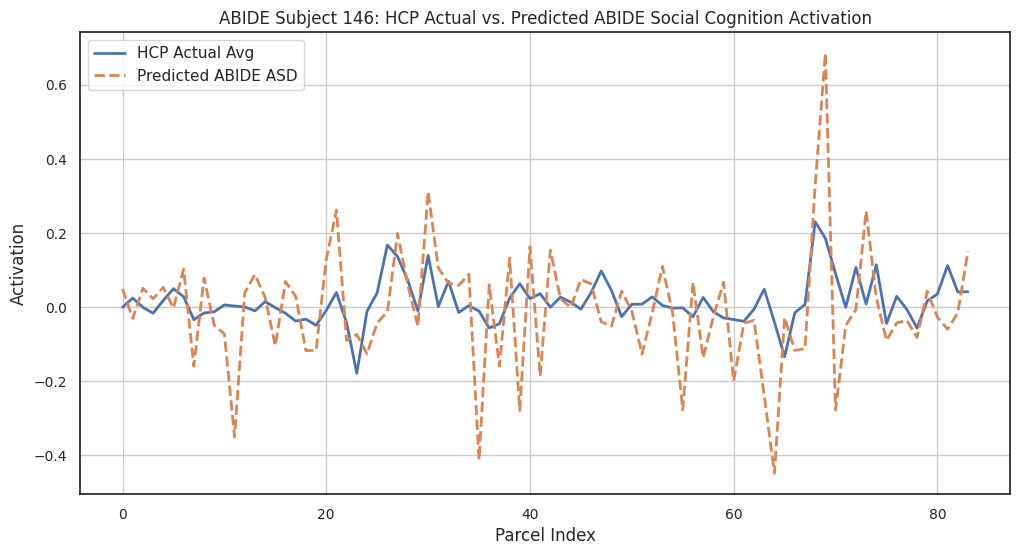

In [45]:
import matplotlib.pyplot as plt

# Choose a subject to visualize (ABIDE subject)
subj_idx = 146

plt.figure(figsize=(12, 6))
plt.plot(activations_social_combined_avg, label="HCP Actual Avg", linewidth=2)
plt.plot(predicted_activations_social_combined_asd[:, subj_idx], label="Predicted ABIDE ASD", linestyle='--', linewidth=2)
plt.title(f"ABIDE Subject {subj_idx}: HCP Actual vs. Predicted ABIDE Social Cognition Activation")
plt.xlabel("Parcel Index")
plt.ylabel("Activation")
plt.legend()
plt.grid(True)
plt.show()

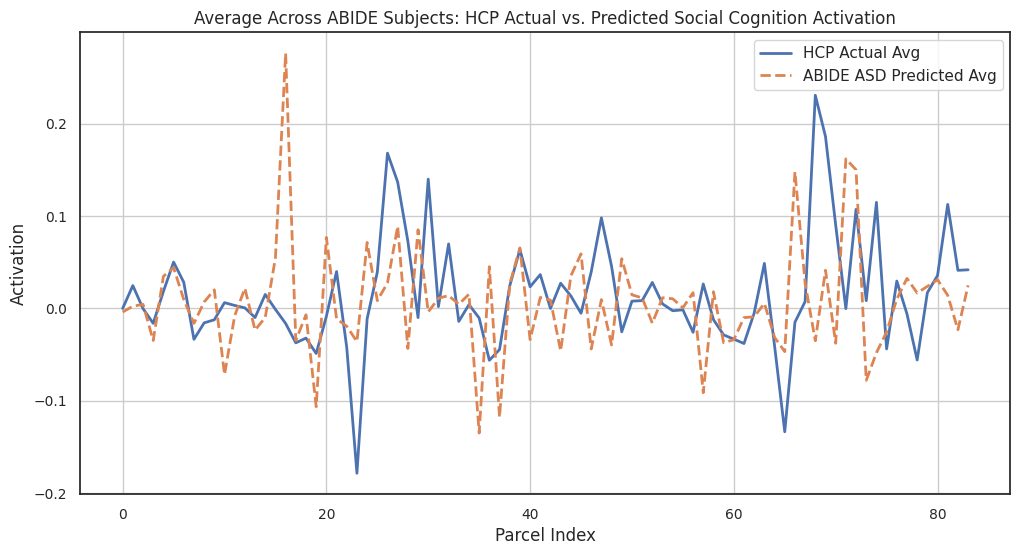

In [46]:
# Average predicted activations across ABIDE subjects
avg_predicted_asd = np.mean(predicted_activations_social_combined_asd, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(activations_social_combined_avg, label="HCP Actual Avg", linewidth=2)
plt.plot(avg_predicted_asd, label="ABIDE ASD Predicted Avg", linestyle='--', linewidth=2)
plt.title("Average Across ABIDE Subjects: HCP Actual vs. Predicted Social Cognition Activation")
plt.xlabel("Parcel Index")
plt.ylabel("Activation")
plt.legend()
plt.grid(True)
plt.show()

Mean Prediction Accuracy (Social-Mental, Simple AFM): 0.068


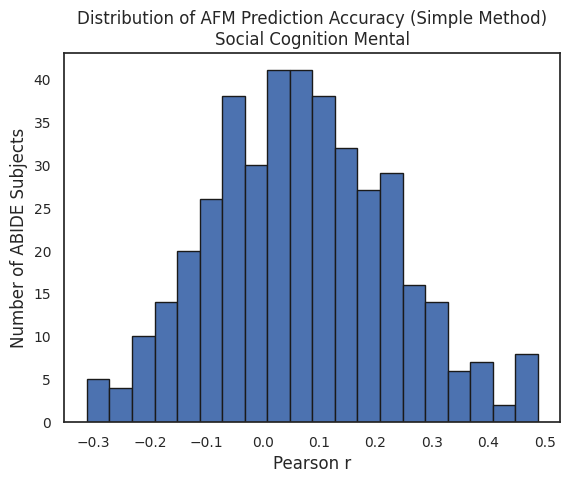

In [47]:
from scipy.stats import pearsonr
import numpy as np

subjectwise_correlations_abide = []

for subj in range(predicted_activations_social_combined_asd.shape[1]):
    predicted = predicted_activations_social_combined_asd[:, subj]
    actual = activations_social_combined_avg
    if np.std(predicted) > 0 and np.std(actual) > 0:
        r = pearsonr(predicted, actual)[0]
        subjectwise_correlations_abide.append(r)
    else:
        subjectwise_correlations_abide.append(np.nan)

mean_accuracy_abide = np.nanmean(subjectwise_correlations_abide)
print(f"Mean Prediction Accuracy (Social-Mental, Simple AFM): {mean_accuracy_abide:.3f}")

plt.hist(subjectwise_correlations_abide, bins=20, edgecolor='k')
plt.title("Distribution of AFM Prediction Accuracy (Simple Method)\nSocial Cognition Mental")
plt.xlabel("Pearson r")
plt.ylabel("Number of ABIDE Subjects")
plt.show()


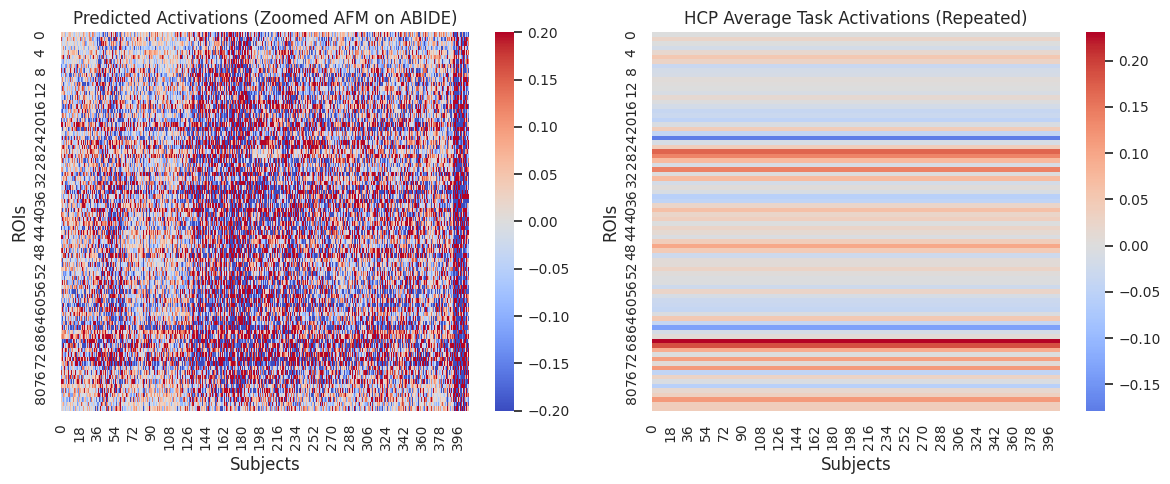

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Heatmap of Predicted Activations (ABIDE) - zoomed scale
plt.subplot(1, 2, 1)
sns.heatmap(predicted_activations_social_combined_asd, cmap="coolwarm", center=0, vmin=-0.2, vmax=0.2)
plt.title("Predicted Activations (Zoomed AFM on ABIDE)")
plt.xlabel("Subjects")
plt.ylabel("ROIs")

# HCP activation (repeated across ABIDE subjects for comparison)
hcp_actual_repeated = np.tile(activations_social_combined_avg[:, np.newaxis], (1, predicted_activations_social_combined_asd.shape[1]))

plt.subplot(1, 2, 2)
sns.heatmap(hcp_actual_repeated, cmap="coolwarm", center=0)
plt.title("HCP Average Task Activations (Repeated)")
plt.xlabel("Subjects")
plt.ylabel("ROIs")

plt.tight_layout()
plt.show()


<ipython-input-49-73f208c68777>:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


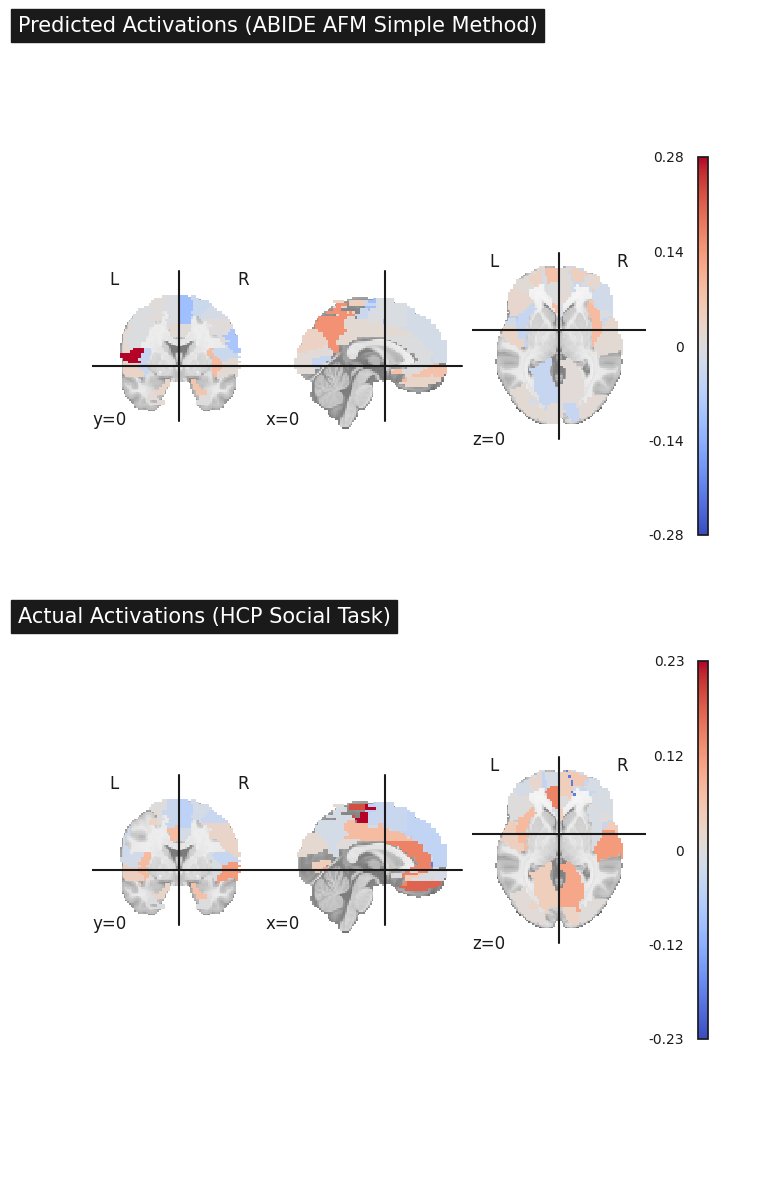

In [49]:
import nibabel as nib
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt

# === Step 1: Map averaged activations to brain volume ===
predicted_activation_map = np.zeros_like(aal_data)
actual_activation_map = np.zeros_like(aal_data)

for idx, label in enumerate(region_labels):
    roi_mask = aal_data == (idx + 1)  # AAL is 1-indexed
    predicted_activation_map[roi_mask] = avg_predicted_asd[idx]
    actual_activation_map[roi_mask] = activations_social_combined_avg[idx]

# === Step 2: Convert to NIfTI images ===
predicted_img = nib.Nifti1Image(predicted_activation_map, aal_img.affine)
actual_img = nib.Nifti1Image(actual_activation_map, aal_img.affine)

# === Step 3: Plot vertically ===
fig, axes = plt.subplots(2, 1, figsize=(8, 12))  # 2 rows, 1 column

# Top: Predicted
display_pred = plotting.plot_stat_map(
    predicted_img,
    title="Predicted Activations (ABIDE AFM Simple Method)",
    display_mode='ortho',
    draw_cross=True,
    cut_coords=(0, 0, 0),
    colorbar=True,
    cmap='coolwarm',
    axes=axes[0]
)

# Bottom: Actual
display_actual = plotting.plot_stat_map(
    actual_img,
    title="Actual Activations (HCP Social Task)",
    display_mode='ortho',
    draw_cross=True,
    cut_coords=(0, 0, 0),
    colorbar=True,
    cmap='coolwarm',
    axes=axes[1]
)

plt.tight_layout()
plt.show()

# ADI-R Score and Predicted Activation Correlation

In [50]:
import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr
from brainspace.null_models import SpinPermutations


# 1. Load Phenotypic Data
pheno_path = '/content/drive/MyDrive/Phenotypic_V1_0b_preprocessed1.csv'
pheno = pd.read_csv(pheno_path)

# Make sure 'SUB_ID' is string
pheno['SUB_ID'] = pheno['SUB_ID'].astype(str)


# 2. Match Subjects with Available ADI-R Scores
adi_scores = []
valid_subject_indices = []

for i, subj in enumerate(selected_subject_ids):
    # clean subject ID: "subject_50649_aal84.npy" → "50649"
    subj_id = subj.replace('subject_', '').replace('_aal84.npy', '')  # extract number
    subj_id = str(int(subj_id))

    # look up subj_id in phenotypic
    match = pheno.loc[pheno['SUB_ID'] == subj_id]

    if not match.empty:
        adi_score = match['ADI_R_VERBAL_TOTAL_BV'].values[0]
        if not np.isnan(adi_score):
            adi_scores.append(adi_score)
            valid_subject_indices.append(i)
        else:
            print(f"Subject {subj_id} has NaN ADI-R score, skipping.")
    else:
        print(f"Subject {subj_id} not found in phenotypic file.")

adi_scores = np.array(adi_scores)

print(f"Matched {len(adi_scores)} subjects with valid ADI-R communication scores.")

Subject 50798 has NaN ADI-R score, skipping.
Subject 50686 has NaN ADI-R score, skipping.
Subject 50689 has NaN ADI-R score, skipping.
Subject 50690 has NaN ADI-R score, skipping.
Subject 50693 has NaN ADI-R score, skipping.
Subject 50694 has NaN ADI-R score, skipping.
Subject 50695 has NaN ADI-R score, skipping.
Subject 50696 has NaN ADI-R score, skipping.
Subject 50697 has NaN ADI-R score, skipping.
Subject 50700 has NaN ADI-R score, skipping.
Subject 50702 has NaN ADI-R score, skipping.
Subject 50704 has NaN ADI-R score, skipping.
Subject 50705 has NaN ADI-R score, skipping.
Subject 50708 has NaN ADI-R score, skipping.
Subject 50711 has NaN ADI-R score, skipping.
Subject 50743 has NaN ADI-R score, skipping.
Subject 50745 has NaN ADI-R score, skipping.
Subject 50746 has NaN ADI-R score, skipping.
Subject 50747 has NaN ADI-R score, skipping.
Subject 50748 has NaN ADI-R score, skipping.
Subject 50749 has NaN ADI-R score, skipping.
Subject 50751 has NaN ADI-R score, skipping.
Subject 50

In [52]:
# 3. Select Predicted Activations for Valid Subjects
predicted_valid = predicted_activations_social_combined_asd[:, valid_subject_indices]
print(f"Predicted activations shape after selection: {predicted_valid.shape}")  # (84, no. with ADI-R scores)

Predicted activations shape after selection: (84, 310)


In [53]:
# 4. Correlate Each ROI Activation with ADI-R Scores
n_rois = predicted_valid.shape[0]
roi_corrs = np.zeros(n_rois)

for roi_idx in range(n_rois):
    r, _ = pearsonr(predicted_valid[roi_idx, :], adi_scores)
    roi_corrs[roi_idx] = r

print("Finished ROI-wise correlations.")

print("ROI-wise correlations with ADI-R communication score:")
for roi_idx in range(n_rois):
    print(f"ROI {roi_idx + 1}: {roi_corrs[roi_idx]:.4f}")

Finished ROI-wise correlations.
ROI-wise correlations with ADI-R communication score:
ROI 1: 0.0765
ROI 2: 0.0028
ROI 3: 0.0413
ROI 4: -0.0927
ROI 5: 0.0453
ROI 6: 0.0199
ROI 7: -0.0449
ROI 8: 0.0179
ROI 9: -0.1684
ROI 10: 0.0135
ROI 11: 0.0580
ROI 12: 0.0136
ROI 13: 0.0502
ROI 14: -0.1312
ROI 15: -0.0197
ROI 16: 0.0140
ROI 17: -0.1761
ROI 18: 0.0270
ROI 19: -0.0435
ROI 20: 0.0250
ROI 21: 0.0966
ROI 22: -0.0350
ROI 23: 0.1259
ROI 24: 0.0535
ROI 25: 0.0540
ROI 26: -0.0436
ROI 27: -0.0486
ROI 28: 0.0380
ROI 29: -0.0658
ROI 30: 0.0275
ROI 31: -0.0689
ROI 32: -0.1446
ROI 33: 0.1112
ROI 34: 0.0331
ROI 35: 0.0343
ROI 36: 0.1146
ROI 37: 0.1330
ROI 38: -0.0402
ROI 39: 0.0589
ROI 40: 0.0429
ROI 41: -0.0148
ROI 42: -0.1384
ROI 43: 0.0432
ROI 44: -0.1308
ROI 45: 0.0055
ROI 46: -0.0703
ROI 47: -0.0977
ROI 48: 0.0007
ROI 49: -0.0286
ROI 50: 0.0876
ROI 51: -0.0575
ROI 52: -0.0664
ROI 53: -0.0430
ROI 54: 0.0202
ROI 55: 0.1084
ROI 56: 0.0261
ROI 57: 0.0132
ROI 58: 0.0113
ROI 59: 0.0210
ROI 60: 0.0340


In [78]:
import numpy as np
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection

# Step 1: calculate r and p-value
n_rois = predicted_valid.shape[0]
roi_corrs = np.zeros(n_rois)
p_values = np.zeros(n_rois)

for roi_idx in range(n_rois):
    r, p = pearsonr(predicted_valid[roi_idx, :], adi_scores)
    roi_corrs[roi_idx] = r
    p_values[roi_idx] = p

print(f"Finished calculating correlations and p-values for {n_rois} ROIs.")

# Step 2: screen out p-value < 0.05
significant_rois = np.where(p_values < 0.05)[0]
print(f"Significant ROIs based on original p-value < 0.05: {significant_rois}")

# print significant ROIs
significant_data = [(roi_idx+1, roi_corrs[roi_idx], p_values[roi_idx]) for roi_idx in significant_rois]
print("\nSignificant ROIs (without FDR correction):")
for roi in significant_data:
    print(f"ROI {roi[0]}: r = {roi[1]:.3f}, Original p-value = {roi[2]:.5f}")


Finished calculating correlations and p-values for 84 ROIs.
Significant ROIs based on original p-value < 0.05: [ 8 13 16 22 31 35 36 41 43 61]

Significant ROIs (without FDR correction):
ROI 9: r = -0.168, Original p-value = 0.00294
ROI 14: r = -0.131, Original p-value = 0.02083
ROI 17: r = -0.176, Original p-value = 0.00185
ROI 23: r = 0.126, Original p-value = 0.02664
ROI 32: r = -0.145, Original p-value = 0.01082
ROI 36: r = 0.115, Original p-value = 0.04377
ROI 37: r = 0.133, Original p-value = 0.01916
ROI 42: r = -0.138, Original p-value = 0.01476
ROI 44: r = -0.131, Original p-value = 0.02126
ROI 62: r = 0.120, Original p-value = 0.03544


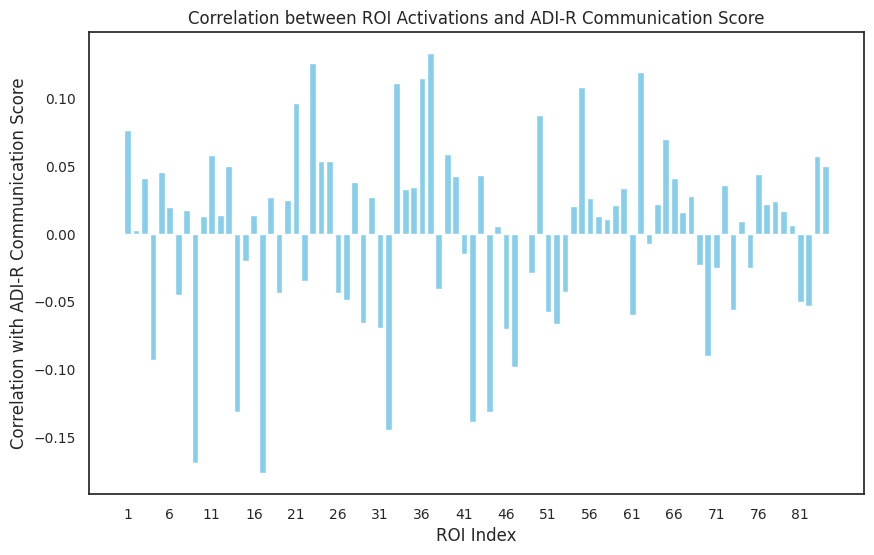

In [54]:
# Plot correlation
import matplotlib.pyplot as plt

# Plot the ROI-wise correlation with ADI-R communication score
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_rois + 1), roi_corrs, color='skyblue')
plt.xlabel('ROI Index')
plt.ylabel('Correlation with ADI-R Communication Score')
plt.title('Correlation between ROI Activations and ADI-R Communication Score')
plt.xticks(range(1, n_rois + 1, 5))  # Show every 5th ROI for readability
plt.show()


Significant ROIs: [ 9 14 17 23 32 33 36 37 42 44 55 62]


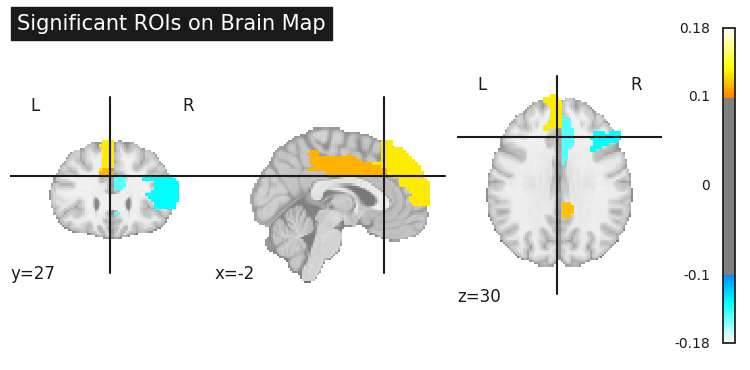

In [57]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting

# Step 1: Load AAL template
aal_path = '/content/drive/MyDrive/AAL_Atlas_MNI_84/AAL84_3mm.nii'
aal_img = nib.load(aal_path)
aal_data = aal_img.get_fdata()  # This is a 3D numpy array representing the AAL labels

# Step 2: Define the correlation threshold (e.g., |r| > 0.3)
threshold = 0.1
significant_rois = np.abs(roi_corrs) > threshold  # roi_corrs is the correlation array

# Step 3: Highlight significant ROIs
significant_roi_indices = np.where(significant_rois)[0]
print(f"Significant ROIs: {significant_roi_indices + 1}")  # Print the ROIs that passed the threshold

# Step 4: Create a mask for significant ROIs
# We will create a binary mask where the significant ROIs are marked with 1
mask_data = np.zeros_like(aal_data)
for roi_idx in significant_roi_indices:
    mask_data[aal_data == roi_idx + 1] = roi_corrs[roi_idx]

# Step 5: Save the significant mask to a NIfTI image
significant_mask_img = nib.Nifti1Image(mask_data, affine=aal_img.affine)
nib.save(significant_mask_img, '/content/drive/MyDrive/AAL_Atlas_MNI_84')  # Replace with your save path

# Step 6: Plot the significant ROIs on the brain template using Nilearn
plotting.plot_stat_map(significant_mask_img, title='Significant ROIs on Brain Map', threshold=0.1, display_mode='ortho', draw_cross=True)

plt.show()


Finished calculating correlations and p-values for 84 ROIs.
Significant ROIs based on original p-value < 0.05: [ 8 13 16 22 31 35 36 41 43 61]

Significant ROIs (without FDR correction):
ROI 9: r = -0.168, Original p-value = 0.00294
ROI 14: r = -0.131, Original p-value = 0.02083
ROI 17: r = -0.176, Original p-value = 0.00185
ROI 23: r = 0.126, Original p-value = 0.02664
ROI 32: r = -0.145, Original p-value = 0.01082
ROI 36: r = 0.115, Original p-value = 0.04377
ROI 37: r = 0.133, Original p-value = 0.01916
ROI 42: r = -0.138, Original p-value = 0.01476
ROI 44: r = -0.131, Original p-value = 0.02126
ROI 62: r = 0.120, Original p-value = 0.03544
Significant ROI mask saved to: /content/drive/MyDrive/significant_rois_mask.nii


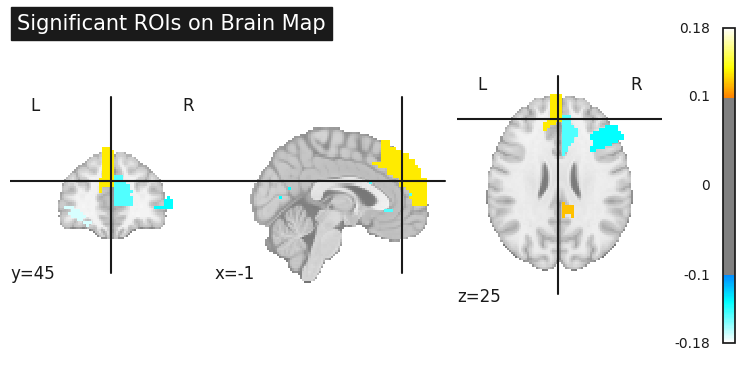

In [79]:
# full script for calculating r, p-values and visualization
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from nilearn import plotting

# Step 1: Calculate correlations (r) and p-values
n_rois = predicted_valid.shape[0]  # 84 ROIs
roi_corrs = np.zeros(n_rois)
p_values = np.zeros(n_rois)

for roi_idx in range(n_rois):
    r, p = pearsonr(predicted_valid[roi_idx, :], adi_scores)
    roi_corrs[roi_idx] = r
    p_values[roi_idx] = p

print(f"Finished calculating correlations and p-values for {n_rois} ROIs.")

# Step 2: Screen out significant ROIs based on p-value < 0.05
significant_rois = np.where(p_values < 0.05)[0]
print(f"Significant ROIs based on original p-value < 0.05: {significant_rois}")

# Step 3: Print significant ROIs with their correlation values and p-values
significant_data = [(roi_idx+1, roi_corrs[roi_idx], p_values[roi_idx]) for roi_idx in significant_rois]
print("\nSignificant ROIs (without FDR correction):")
for roi in significant_data:
    print(f"ROI {roi[0]}: r = {roi[1]:.3f}, Original p-value = {roi[2]:.5f}")

# Step 4: Load AAL template (MNI coordinates)
aal_path = '/content/drive/MyDrive/AAL_Atlas_MNI_84/AAL84_3mm.nii'  # Update with your AAL file path
aal_img = nib.load(aal_path)
aal_data = aal_img.get_fdata()  # 3D numpy array of AAL labels

# Step 5: Create a mask for significant ROIs (highlighted based on correlation value)
mask_data = np.zeros_like(aal_data)  # Initialize a mask array with zeros

# Loop through each significant ROI and update the mask data
for roi_idx in significant_rois:
    mask_data[aal_data == roi_idx + 1] = roi_corrs[roi_idx]  # Assign correlation values to the mask

# Step 6: Save the mask as a NIfTI image
output_mask_path = '/content/drive/MyDrive/significant_rois_mask.nii'  # Change to your preferred save path
significant_mask_img = nib.Nifti1Image(mask_data, affine=aal_img.affine)
nib.save(significant_mask_img, output_mask_path)
print(f"Significant ROI mask saved to: {output_mask_path}")

# Step 7: Plot the significant ROIs on the brain template using Nilearn
plotting.plot_stat_map(significant_mask_img, title='Significant ROIs on Brain Map', threshold=0.1, display_mode='ortho', draw_cross=True, colorbar=True)

# Display the plot
plt.show()


###corresponding regions:
ROI 9 (Left Middle frontal gyrus, orbital part): r = -0.168, Original p-value = 0.00294

ROI 14 (Right Inferior frontal gyrus, triangular part): r = -0.131, Original p-value = 0.02083

ROI 17 (Left Rolandic operculum): r = -0.176, Original p-value = 0.00185

ROI 23 (Left Superior frontal gyrus, medial): r = 0.126, Original p-value = 0.02664

ROI 32 (Right Anterior cingulate and paracingulate gyri): r = -0.145, Original p-value = 0.01082

ROI 36 (Right Posterior cingulate gyrus): r = 0.115, Original p-value = 0.04377

ROI 37 (Left Parahippocampal gyrus): r = 0.133, Original p-value = 0.01916

ROI 42 (Right Cuneus): r = -0.138, Original p-value = 0.01476

ROI 44 (Right Lingual gyrus): r = -0.131, Original p-value = 0.02126

ROI 62 (Right Angular gyrus): r = 0.120, Original p-value = 0.03544


In [70]:
# 5. Spin Permutation

aal_coords_df = pd.read_csv('/content/drive/MyDrive/AAL_Atlas_MNI_84/AAL_84_Coords.csv',header = None)
print(aal_coords_df.head())

aal_coords = aal_coords_df.to_numpy()

# Normalize to sphere
aal_coords_norm = aal_coords / np.linalg.norm(aal_coords, axis=1, keepdims=True)
print(f"Normalized AAL coordinates shape: {aal_coords_norm.shape}")


       0      1      2
0 -38.65  -5.68  50.94
1  41.37  -8.21  52.09
2 -18.45  34.81  42.20
3  21.90  31.12  43.82
4 -16.56  47.32 -13.31
Normalized AAL coordinates shape: (84, 3)


In [75]:
# Set up spin permutation
sp = SpinPermutations(n_rep=1000, random_state=2025)
sp.fit(aal_coords_norm)

# Apply spin
spun_maps = sp.randomize(roi_corrs)

# Calculate permutation correlations
spin_corrs = np.array([
    np.corrcoef(spun_map, roi_corrs)[0, 1]
    for spun_map in spun_maps
])

real_corr = np.corrcoef(roi_corrs, roi_corrs)[0,1]

# Two-tailed p-value
p_value = (np.sum(np.abs(spin_corrs) >= np.abs(real_corr)) + 1) / (len(spin_corrs) + 1)

print(f"Spin permutation p-value: {p_value:.5f}")

Spin permutation p-value: 0.00100
